In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy
import pickle

In [2]:
warnings.simplefilter("ignore")

howmanydifs = 3
allvalues_perset = pickle.load(open("allvalues_perset.p", "rb"))
methods = pickle.load(open("methods.p", "rb"))
fullsetnames = pickle.load(open("fullsetnames.p", "rb"))
functionals = pickle.load(open("functionals.p", "rb"))
basis_sets = pickle.load(open("basis_sets.p", "rb"))
supersetnames = pickle.load(open("supersetnames.p", "rb"))

In [3]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
        wtmad = wtmadf["Full"]

        if wtmad < models_results[setname].bestinsidemethod_wtmad:
            models_results[setname].bestinsidemethod_wtmad = wtmad
            models_results[setname].bestinsidemethod_name_wtmad = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                models_results[setname].labels, y_pred)
        wtmad = wtmadf["Full"]

        if wtmad < models_results[setname].bestourmethod_wtmad:
            models_results[setname].bestourmethod_wtmad = wtmad
            models_results[setname].bestourmethod_name_wtmad = method
            models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           0  ,    8.201  ,           0  ,    8.040  ,   PBE0-TZVP  ,    4.856  ,   PBE0-TZVP  ,    4.970
                    BARRIER_HEIGHTS_BH76  ,           0  ,   10.387  ,           0  ,    9.150  ,   PBE0-TZVP  ,    5.505  ,   PBE0-TZVP  ,    5.000
                 BARRIER_HEIGHTS_BHDIV10  ,           0  ,    9.191  ,           0  ,    8.230  ,   PBE0-TZVP  ,    5.278  ,   PBE0-TZVP  ,    4.800
                  BARRIER_HEIGHTS_BHPERI  ,           0  ,    4.407  ,           0  ,    3.950  ,   PBE0-TZVP  ,    3.762  ,   PBE0-TZVP  ,    3.510
                 BARRIER_HEIGHTS_BHROT27  ,           1  ,    0.611  ,           1  ,    0.420  ,    PBE-TZVP  ,    0.718  ,    PBE-TZVP  ,    0.540
                   BARRIER_HE

In [5]:
#build descriptors 
selected_basisset = "TZVP"
selected_functional = "PBE"
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
for setname in fullsetnames:
    desciptors = {}
    for val in allvalues_perset[setname]:
        for func in functionals:
            for basis in basis_sets:
                if basis == selected_basisset and func == selected_functional:
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        if k2 not in desciptors:
                            desciptors[k2] = [val[k][k2]]
                        else:
                            desciptors[k2].append(val[k][k2])
                else:
                    refk  = selected_functional + "-" + selected_basisset + "_energydiff"
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        refk2 = k2.replace(basis, selected_basisset)
                        refk2 = refk2.replace(func, selected_functional)
                        newk2 = k2 + "_difftoref"
                        if newk2 not in desciptors:
                            desciptors[newk2] = [val[refk][refk2] - val[k][k2]]
                        else:
                            desciptors[newk2].append(val[refk][refk2] - val[k][k2])
    models_results[setname].features = desciptors
    #print("Descriptors for ", setname)
    #for k in desciptors:
    #    print(k, len(desciptors[k]), desciptors[k])

# feastures selection
setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

toremove = []
setname = "Full"
for k in models_results[setname].features:
    if len(set(models_results[setname].features[k])) == 1:
        toremove.append(k)
        print("Constant fatures to remove: ", k)

# remove constant values
for setname in fullsetnames:
    #print("Removing constant features for ", setname)
    for k in toremove:
        #print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
print("Removing Nuclear Repulsion difference")
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("Nuclear_Repulsion_difftoref") != -1:
            toremove.append(k)
    for k in toremove:
        #print("Removing feature ", k)
        del models_results[setname].features[k]

setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

Number of features for  108
Constant fatures to remove:  PBE-MINIX_Dispersion_correction_difftoref
Constant fatures to remove:  PBE-SVP_Dispersion_correction_difftoref
Constant fatures to remove:  PBE-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE0-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE0-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSS-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSS-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSSh-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSSh-TZVP_Nuclear_Repulsion_difftoref
Removing Nuclear Repulsion difference
Number of features for  95


In [6]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

In [7]:
# remove corralted features 
CORRCUT = 0.95

setname = "Full"
touse = set()
# add by default the selected FINAL_SINGLE_POINT_ENERGY
touse.add(selected_functional + "-" + \
            selected_basisset + "_" + \
            "FINAL_SINGLE_POINT_ENERGY")
toremove = set()
df = pd.DataFrame(models_results[setname].features)
corr = df.corr().abs()
for i, k in enumerate(corr.columns):
    print(i+1, " - ", k, " ", i)
    if k not in toremove:
        touse.add(k)
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and idx > i:
            print(" %60s %4.2f"%(corr.index[idx], v))
            if corr.index[idx] not in touse:
                toremove.add(corr.index[idx])

print("Features to use")
for i, feat in enumerate(touse):
    print(i+1 ,  " - " , feat)

for setname in fullsetnames:
    for k in touse:
        models_results[setname].uncorrelated_features[k] = \
            deepcopy(models_results[setname].features[k])

1  -  PBE-MINIX_One_Electron_Energy_difftoref   0
                      PBE-MINIX_Two_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_Two_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_Two_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_One_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_Two_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_One_Electron_Energy_difftoref 1.00
2  -  PBE-MINIX_Two_Electron_Energy_difftoref   1
                     PBE0-MINIX_Two_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_Two_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_One_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_Two_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_One_Electron_Energy_difftoref 1.00
3  -  PBE-MINIX_FINAL_SINGLE_

Correlation matrix


<Axes: >

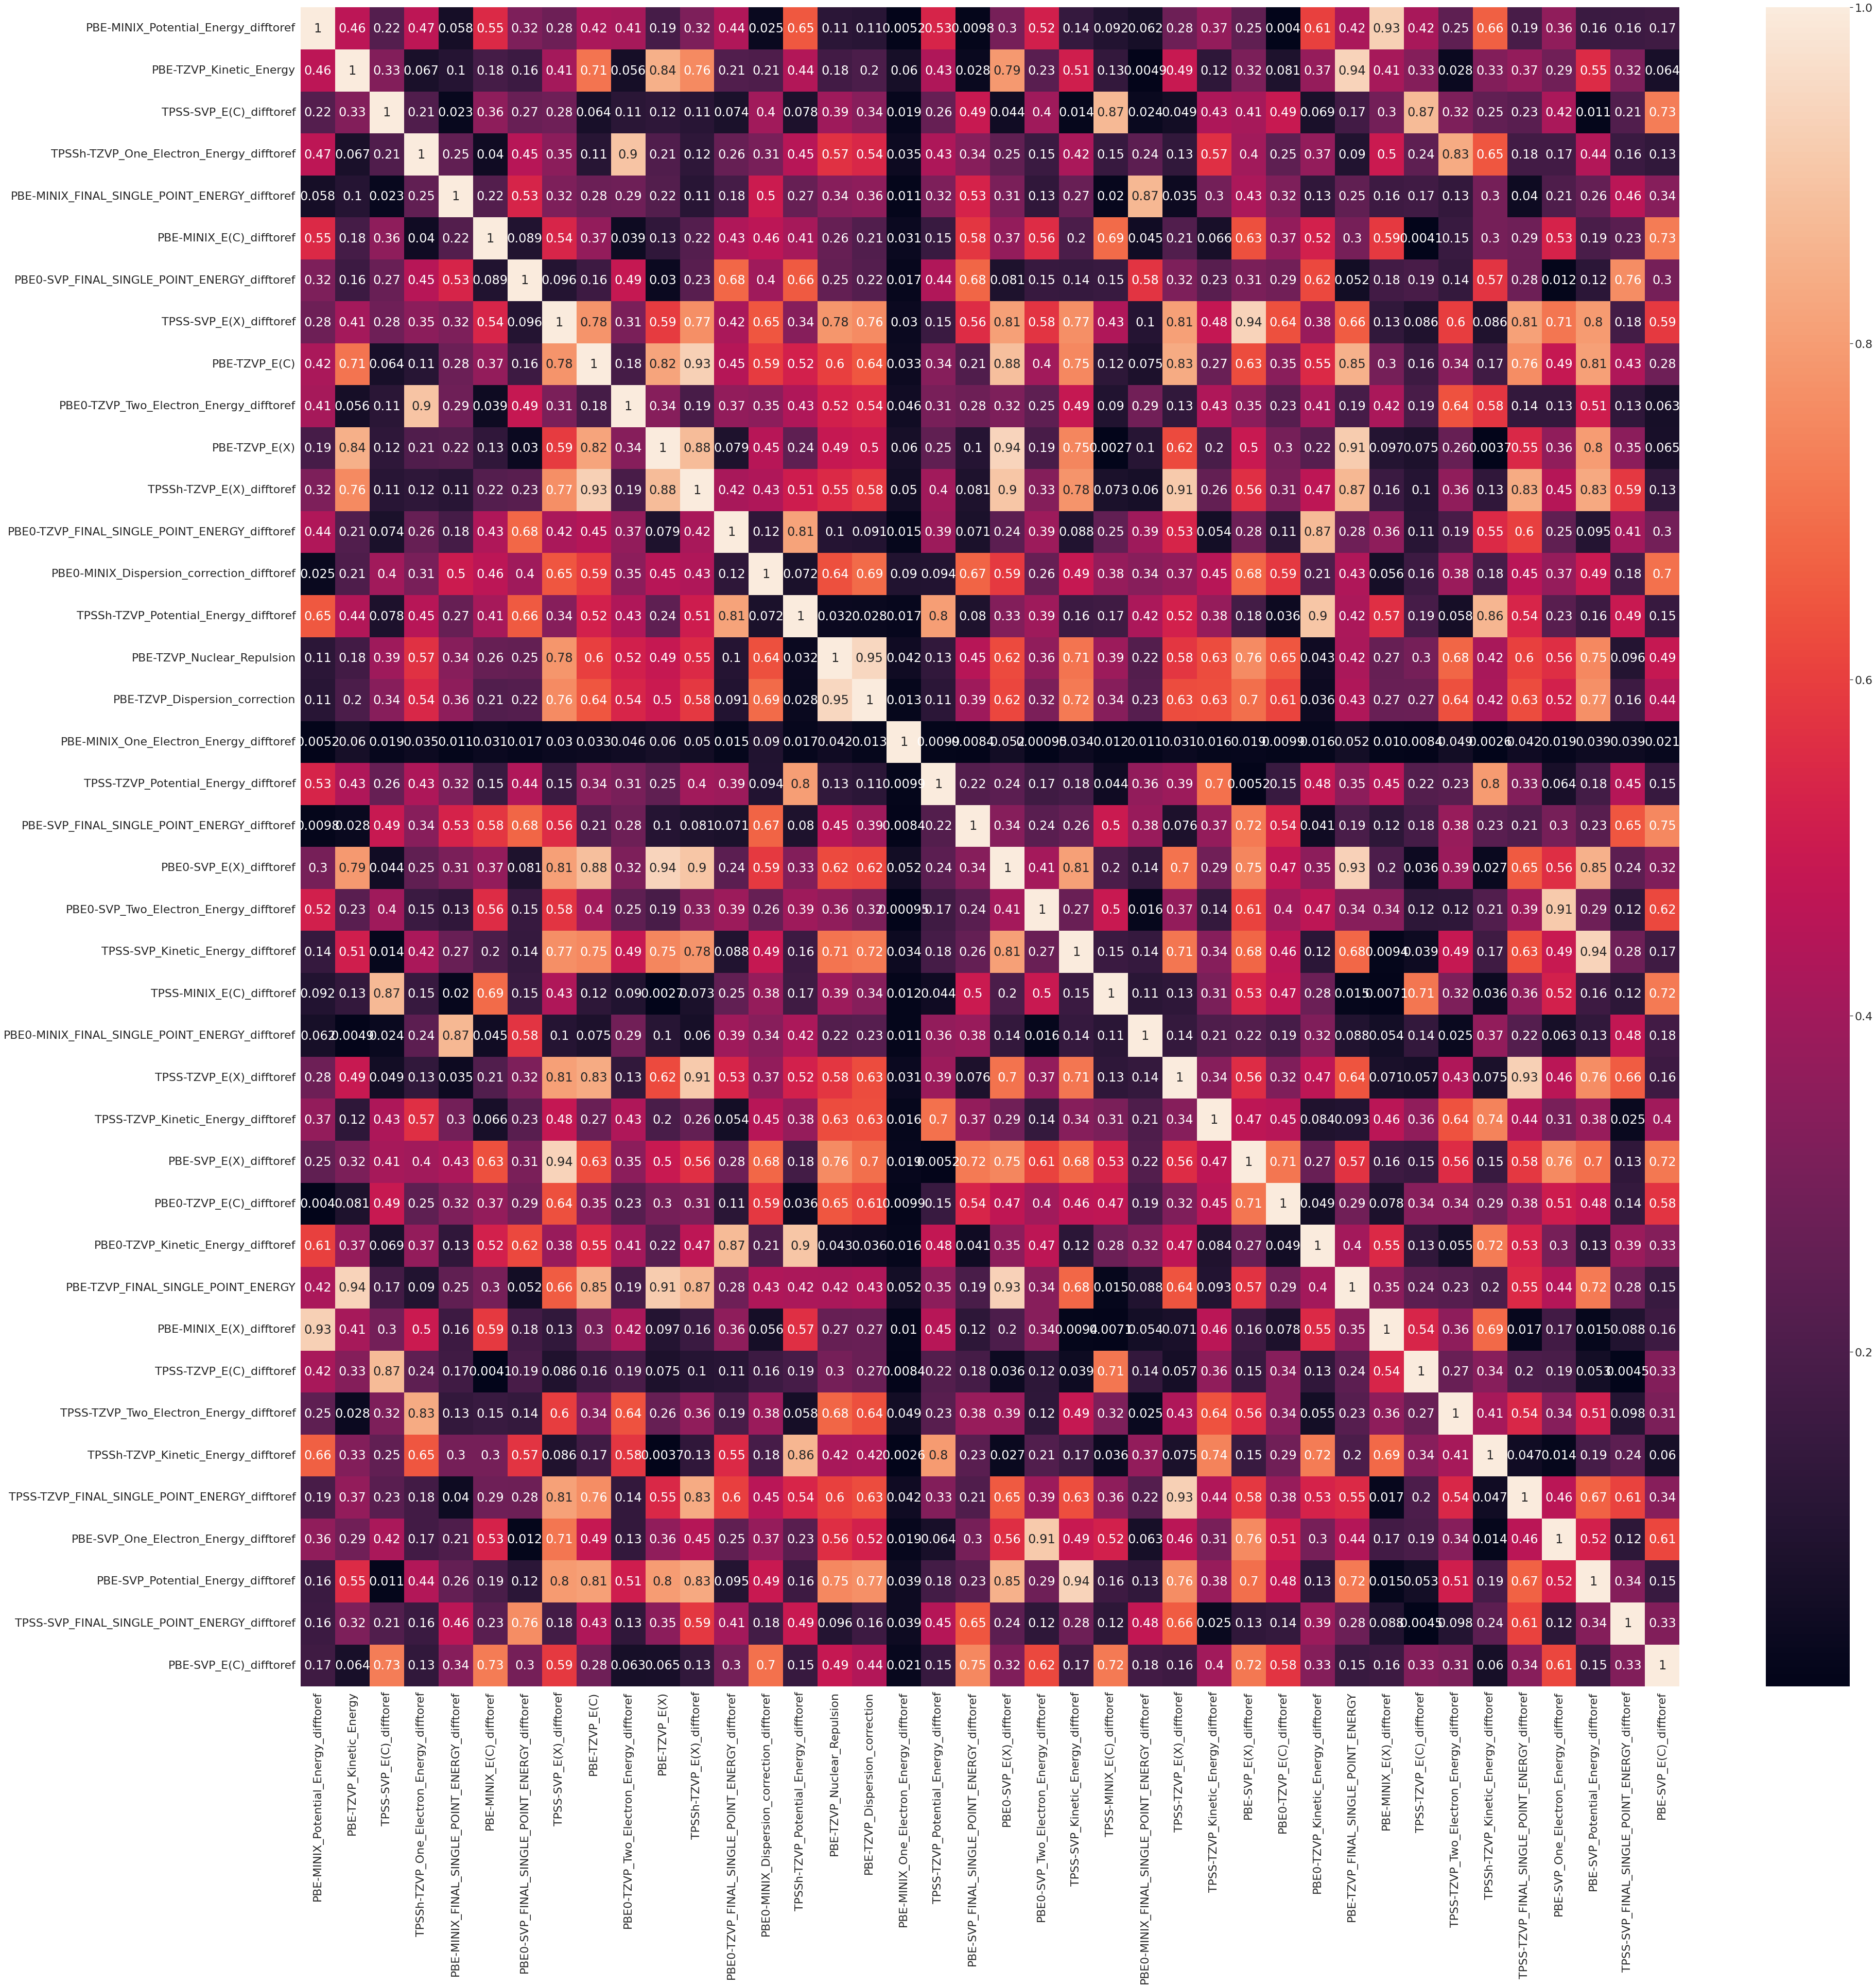

In [8]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    i = 1
#    for k in models_results[setname].features:
#        print(i, " - ", k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])
#        i += 1

import seaborn as sns
%matplotlib inline

setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 60,60
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [9]:
#compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


df = pd.DataFrame(models_results["Full"].uncorrelated_features)
vif = pd.DataFrame()
#scale data before computing VIF
df = df.apply(lambda x: (x - np.mean(x)) / np.std(x))
vif["features"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
print("VIF")
for v in vif.values:
    if v[1] > 100:
        print(v[0], v[1])
        for setname in fullsetnames:
            if v[0] in models_results[setname].uncorrelated_features:
                del models_results[setname].uncorrelated_features[v[0]]

VIF
TPSS-SVP_E(C)_difftoref 882.0703528409299
PBE-MINIX_E(C)_difftoref 192.0382311946776
PBE0-SVP_FINAL_SINGLE_POINT_ENERGY_difftoref 1723.283171450536
TPSS-SVP_E(X)_difftoref 884.6412932283988
PBE-TZVP_E(X) 889.90286459896
TPSSh-TZVP_E(X)_difftoref 2558.046179120277
PBE0-TZVP_FINAL_SINGLE_POINT_ENERGY_difftoref 8462.210037164023
TPSSh-TZVP_Potential_Energy_difftoref 334168.71488927474
PBE-TZVP_Dispersion_correction 698.7259366734878
TPSS-TZVP_Potential_Energy_difftoref 123563.91864570837
PBE-SVP_FINAL_SINGLE_POINT_ENERGY_difftoref 1979.520409166531
PBE0-SVP_E(X)_difftoref 2758.3988059486774
PBE0-SVP_Two_Electron_Energy_difftoref 144.36988841141832
TPSS-MINIX_E(C)_difftoref 316.87557945475135
TPSS-TZVP_E(X)_difftoref 896.959904966341
TPSS-TZVP_Kinetic_Energy_difftoref 149963.91636466212
PBE-SVP_E(X)_difftoref 759.5875714542493
TPSS-TZVP_E(C)_difftoref 293.2585975418081
TPSSh-TZVP_Kinetic_Energy_difftoref 208953.33270228948
TPSS-TZVP_FINAL_SINGLE_POINT_ENERGY_difftoref 21519.15256685511

Correlation matrix


<Axes: >

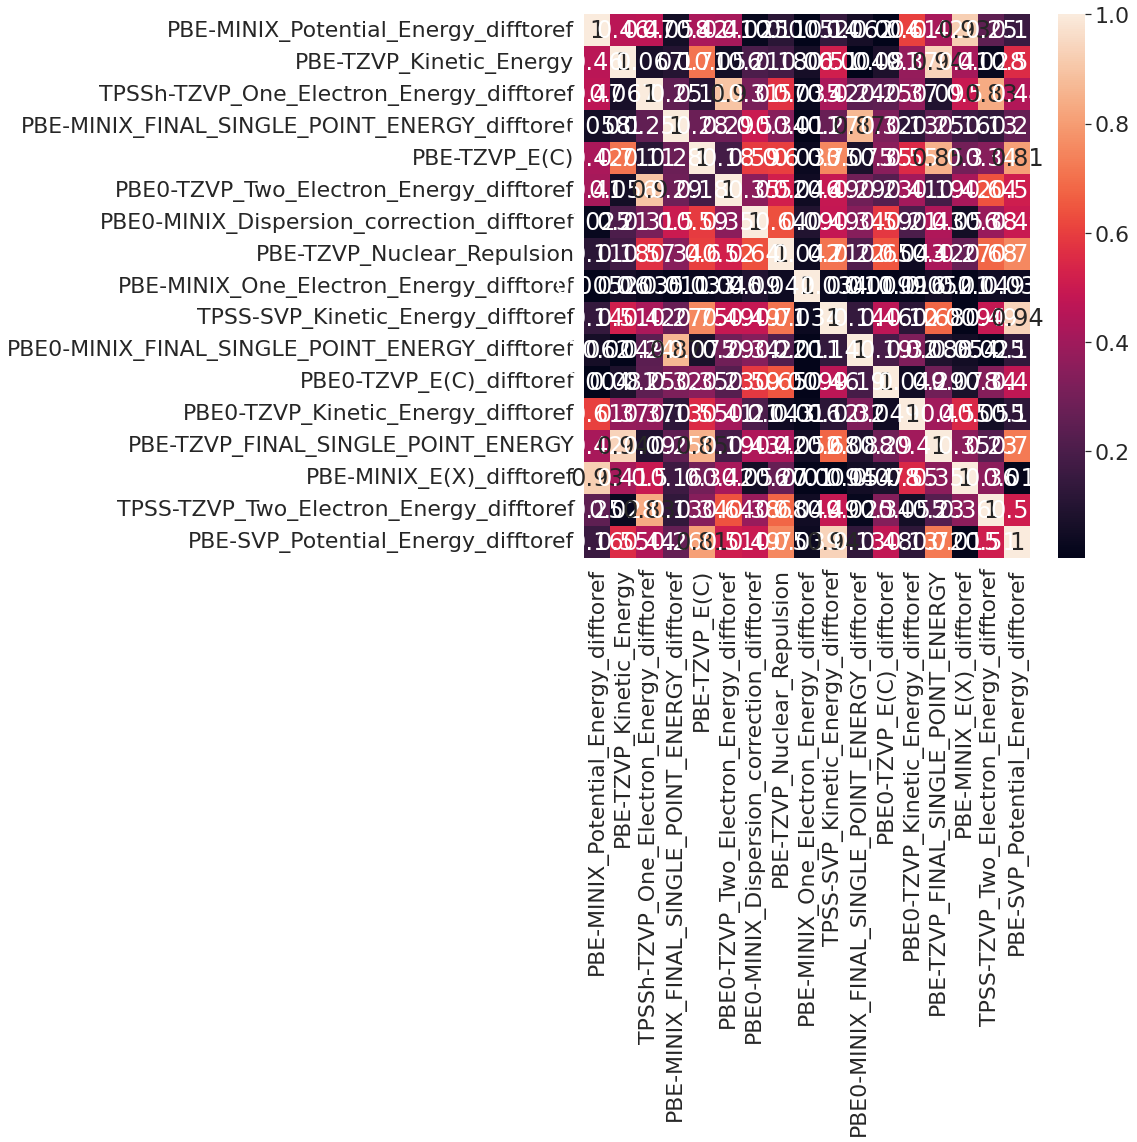

In [10]:
setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)

Running PLS for dataset:  BARRIER_HEIGHTS


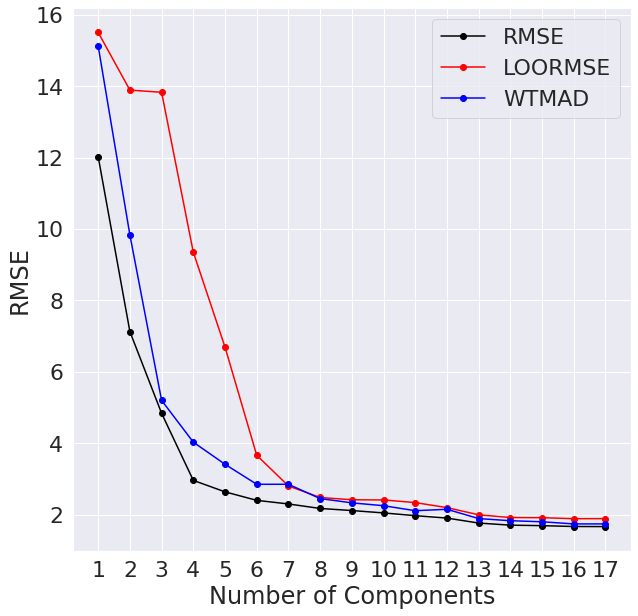

Best number of components for       R2:   17 [    0.99]
Best number of components for     RMSE:   17 [    1.67]
Best number of components for    WTMAD:   16 [    1.74]
Best number of components for LOO RMSE:   16 [    1.89]
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS


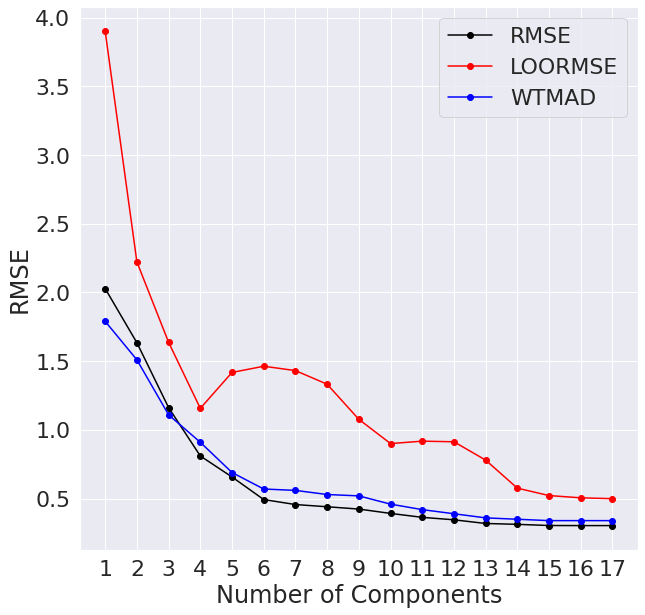

Best number of components for       R2:   17 [    1.00]
Best number of components for     RMSE:   17 [    0.30]
Best number of components for    WTMAD:   15 [    0.34]
Best number of components for LOO RMSE:   17 [    0.50]
Running PLS for dataset:  SMALL_MOLECULES


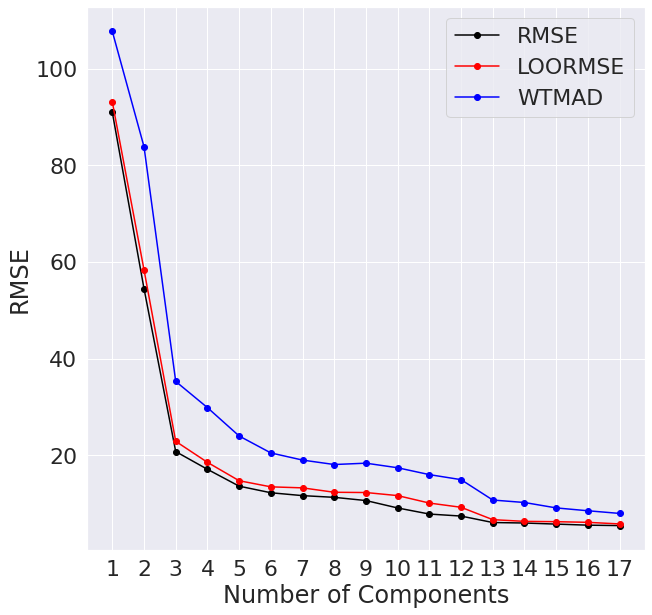

Best number of components for       R2:   17 [    1.00]
Best number of components for     RMSE:   17 [    5.42]
Best number of components for    WTMAD:   17 [    7.94]
Best number of components for LOO RMSE:   17 [    5.76]
Running PLS for dataset:  INTERMOLECULAR_INTERACTIONS


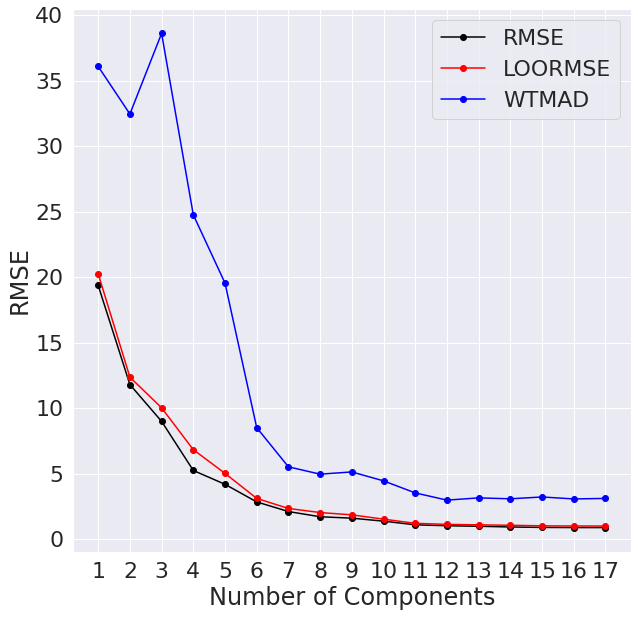

Best number of components for       R2:   17 [    1.00]
Best number of components for     RMSE:   17 [    0.90]
Best number of components for    WTMAD:   12 [    3.00]
Best number of components for LOO RMSE:   17 [    1.02]
Running PLS for dataset:  LARGE_SYSTEMS


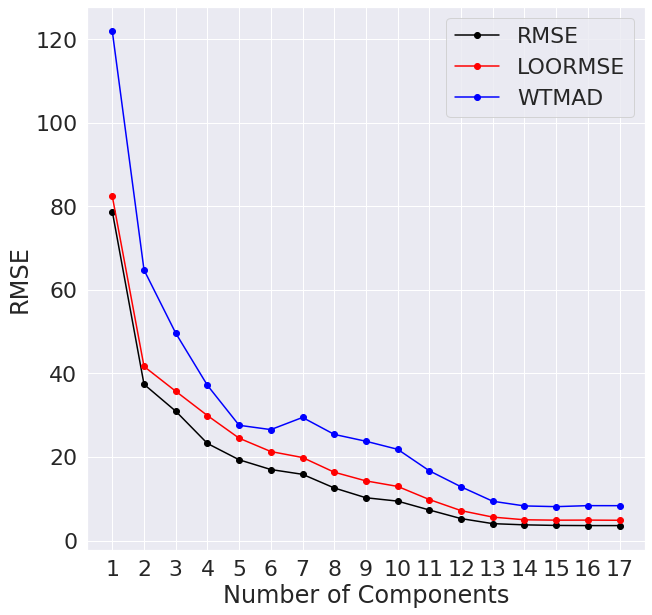

Best number of components for       R2:   17 [    1.00]
Best number of components for     RMSE:   17 [    3.57]
Best number of components for    WTMAD:   15 [    8.11]
Best number of components for LOO RMSE:   17 [    4.85]
Running PLS for dataset:  Full


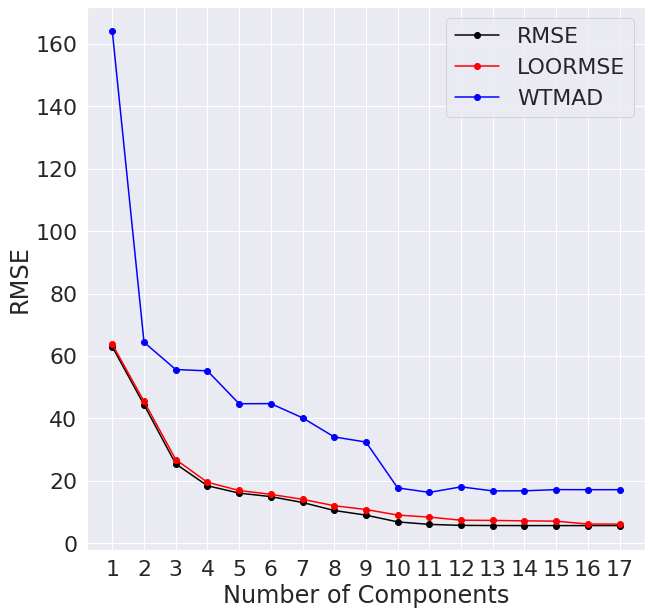

Best number of components for       R2:   17 [    1.00]
Best number of components for     RMSE:   17 [    5.63]
Best number of components for    WTMAD:   11 [   16.27]
Best number of components for LOO RMSE:   17 [    6.10]


In [11]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

comptuseperset = {}
for setname in list(supersetnames)+["Full"]:
    comptuseperset[setname] = 0

perc_split = 0.2
for setname in list(supersetnames)+["Full"]:
   print("Running PLS for dataset: ", setname)

   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = []
   for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
   supersetlist = models_results[setname].supersetnames
   maxcomp = X.shape[1]
   ncomps, rmses, r2s, wtmads, loormses = \
          models.pls_model (X, Y, supersetlist, setlist, \
          ncomp_start = 1, ncomp_max = maxcomp, split = False,\
          plot = True)
   r2max_comps = np.argmax(r2s)+1
   rmsemin_comps = np.argmin(rmses)+1
   wtmadmin_comps = np.argmin(wtmads)+1
   loormsemin_comps = np.argmin(loormses)+1
   print("Best number of components for       R2: %4d [%8.2f]"%(\
      r2max_comps, r2s[r2max_comps-1]))
   print("Best number of components for     RMSE: %4d [%8.2f]"%(\
      rmsemin_comps, rmses[rmsemin_comps-1]))
   print("Best number of components for    WTMAD: %4d [%8.2f]"%(\
      wtmadmin_comps, wtmads[wtmadmin_comps-1]))
   print("Best number of components for LOO RMSE: %4d [%8.2f]"%(\
      loormsemin_comps, loormses[loormsemin_comps-1]))

   compstouse = wtmadmin_comps
   comptuseperset[setname] = compstouse


   

In [12]:
# select components to use
comptuseperset["BARRIER_HEIGHTS"] = 13
comptuseperset["INTRAMOLECULAR_INTERACTIONS"] = 14
comptuseperset["SMALL_MOLECULES"] = 16
comptuseperset["INTERMOLECULAR_INTERACTIONS"] = 12
comptuseperset["LARGE_SYSTEMS"] = 13
comptuseperset["Full"] = 14
for setname in list(supersetnames)+["Full"]:   
   print("Running PLS for dataset: ", setname)
   print("  Using ", comptuseperset[setname], " components")
   compstouse = comptuseperset[setname]
   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = []
   for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)

   models_results[setname].plsmodel = PLSRegression(n_components=compstouse)
   models_results[setname].plsmodel.fit(X, Y)
   models_results[setname].y_pred = \
      models_results[setname].plsmodel.predict(X) 
   
   cv = LeaveOneOut()
   model = PLSRegression(n_components=compstouse)
   scores = cross_val_score(model, X, Y, \
            scoring='neg_mean_squared_error', \
            cv=cv, n_jobs=-1)
   loormse = np.sqrt(np.mean(np.absolute(scores)))
   rmse = mean_squared_error(Y, models_results[setname].y_pred, squared=False)
   r2 = r2_score(Y, models_results[setname].y_pred)
   y_pred = models_results[setname].y_pred
   if len(y_pred.shape) == 2:
            y_pred = y_pred[:,0]
   wtmadf = commonutils.wtmad2(setlist, Y, y_pred)
   wtmad = wtmadf["Full"]
   print("      RMSE: %10.2f"%rmse)
   print("        R2: %10.2f"%r2)
   print("     WTMAD: %10.2f"%wtmad)
   print("  LOO RMSE: %10.2f"%loormse)

Running PLS for dataset:  BARRIER_HEIGHTS
  Using  13  components
      RMSE:       1.76
        R2:       0.99
     WTMAD:       1.89
  LOO RMSE:       2.00
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS
  Using  14  components
      RMSE:       0.31
        R2:       1.00
     WTMAD:       0.35
  LOO RMSE:       0.58
Running PLS for dataset:  SMALL_MOLECULES
  Using  16  components
      RMSE:       5.51
        R2:       1.00
     WTMAD:       8.49
  LOO RMSE:       6.09
Running PLS for dataset:  INTERMOLECULAR_INTERACTIONS
  Using  12  components
      RMSE:       1.04
        R2:       1.00
     WTMAD:       3.00
  LOO RMSE:       1.15
Running PLS for dataset:  LARGE_SYSTEMS
  Using  13  components
      RMSE:       4.04
        R2:       1.00
     WTMAD:       9.40
  LOO RMSE:       5.61
Running PLS for dataset:  Full
  Using  14  components
      RMSE:       5.63
        R2:       1.00
     WTMAD:      16.78
  LOO RMSE:       7.16


In [13]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE (superset) ," + \
      "RMSE (Full)")
pls_model_full = models_results["Full"].plsmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
y_pred = pls_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%rmse)

for ssetname in supersetnames:
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].uncorrelated_features, \
                                    models_results[ssetname].labels)
    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)

    y_pred_full = pls_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname 
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)

        y_pred_ssetname = pls_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)

        y_pred_full = pls_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%rmse_full)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE (superset) ,RMSE (Full)
1505 ,                                     Full  ,    9.227  ,    6.219  ,    5.633  ,    5.633
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    4.856  ,    1.764  ,    4.811
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,    5.505  ,    2.152  ,    5.533
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    5.278  ,    2.364  ,    5.982
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    3.762  ,    1.036  ,    3.140
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.718  ,    0.823  ,    1.657
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    1.534  ,    1.371  ,    7.025
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,    8.204  ,    1.460  ,    2.402
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    5.887  ,    2.067  ,    3.463
 2

Results for  BARRIER_HEIGHTS  dim:  194
WTAMD2     (PLS ssetname)   1.890
WTAMD2         (PLS Full)   4.910
WTAMD2 (bestinsidemethod)   8.040
WTAMD2    (bestourmethod)   4.970
RMSE       (PLS ssetname)   1.764
RMSE           (PLS Full)   4.811
RMSE   (bestinsidemethod)   8.201
RMSE      (bestourmethod)   4.856


<Figure size 720x720 with 0 Axes>

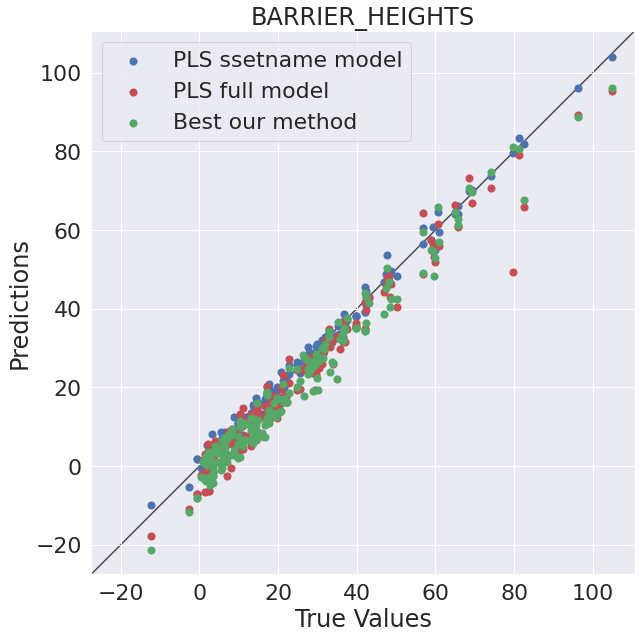

Results for  INTRAMOLECULAR_INTERACTIONS  dim:  291
WTAMD2     (PLS ssetname)   0.350
WTAMD2         (PLS Full)   1.420
WTAMD2 (bestinsidemethod)   0.690
WTAMD2    (bestourmethod)   0.640
RMSE       (PLS ssetname)   0.313
RMSE           (PLS Full)   1.298
RMSE   (bestinsidemethod)   0.873
RMSE      (bestourmethod)   0.589


<Figure size 720x720 with 0 Axes>

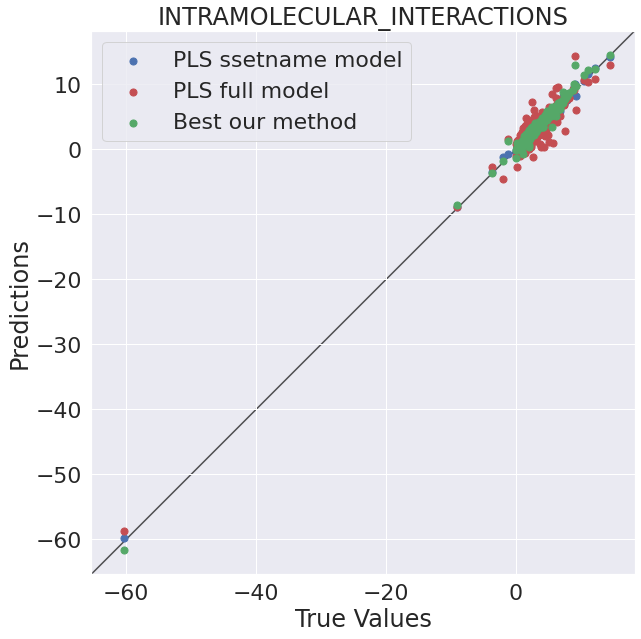

Results for  SMALL_MOLECULES  dim:  473
WTAMD2     (PLS ssetname)   8.490
WTAMD2         (PLS Full)  10.200
WTAMD2 (bestinsidemethod)  13.010
WTAMD2    (bestourmethod)  10.140
RMSE       (PLS ssetname)   5.510
RMSE           (PLS Full)   6.809
RMSE   (bestinsidemethod)  12.191
RMSE      (bestourmethod)   6.291


<Figure size 720x720 with 0 Axes>

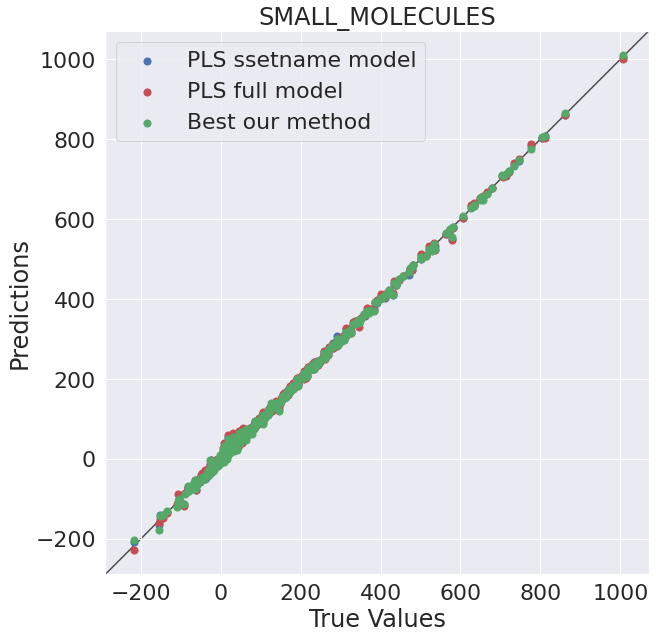

Results for  INTERMOLECULAR_INTERACTIONS  dim:  304
WTAMD2     (PLS ssetname)   3.000
WTAMD2         (PLS Full)  17.000
WTAMD2 (bestinsidemethod)   3.720
WTAMD2    (bestourmethod)   4.020
RMSE       (PLS ssetname)   1.044
RMSE           (PLS Full)   3.714
RMSE   (bestinsidemethod)   2.286
RMSE      (bestourmethod)   5.970


<Figure size 720x720 with 0 Axes>

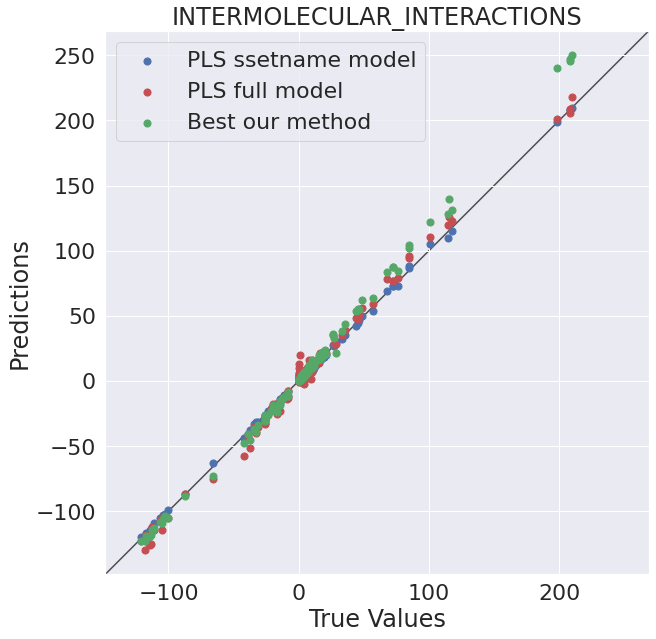

Results for  LARGE_SYSTEMS  dim:  243
WTAMD2     (PLS ssetname)   9.400
WTAMD2         (PLS Full)  12.500
WTAMD2 (bestinsidemethod)  16.050
WTAMD2    (bestourmethod)  11.320
RMSE       (PLS ssetname)   4.039
RMSE           (PLS Full)   8.280
RMSE   (bestinsidemethod)  12.567
RMSE      (bestourmethod)   9.042


<Figure size 720x720 with 0 Axes>

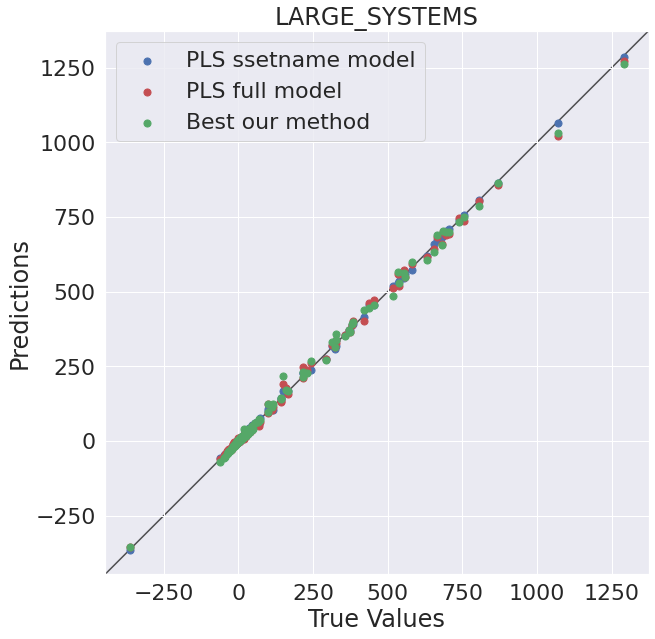

Results for Full sim  1505
WTAMD2     (PLS ssetname)   5.470
WTAMD2         (PLS Full)  16.780
WTAMD2 (bestinsidemethod)  10.160
WTAMD2    (bestourmethod)   8.160
RMSE       (PLS ssetname)   3.580
RMSE           (PLS Full)   5.633
RMSE   (bestinsidemethod)   9.227
RMSE      (bestourmethod)   6.219


<Figure size 720x720 with 0 Axes>

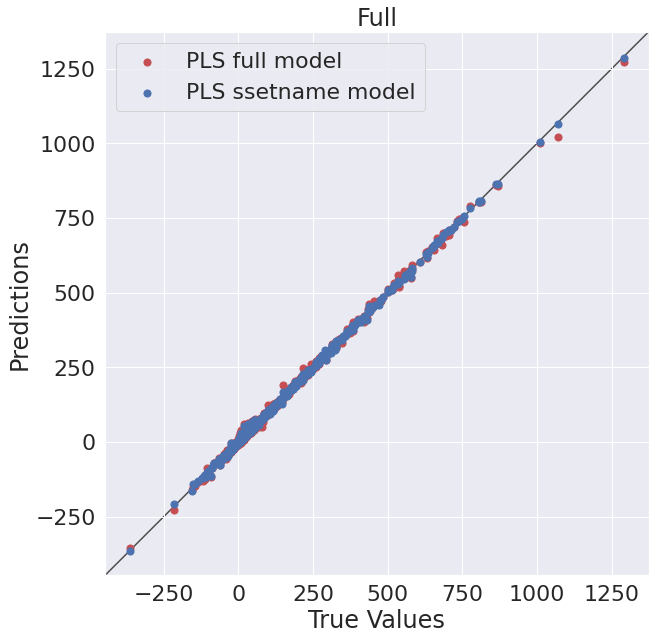

In [14]:
setname = "Full"
pls_model_full = models_results[setname].plsmodel
printonlysuperset = True
setnametouse = deepcopy(fullsetnames)
setnametouse.remove("Full")

ypredFull = []
setnamesFull = []

for setname in setnametouse:
    if setname in supersetnames:
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    setlist = []
    for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
    
    y_pred_full = pls_model_full.predict(X)
    if len(y_pred_full.shape) == 2:
        y_pred_full = y_pred_full[:,0]
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    y_pred = pls_model_ssetname.predict(X)
    if len(y_pred.shape) == 2:
        y_pred = y_pred[:,0]
    rmse = mean_squared_error(Y, y_pred, squared=False)
    
    if setname in supersetnames:
        ypredFull.extend(list(y_pred))
        setnamesFull.extend(setlist)
        print("Results for ", setname, " dim: ", len(Y))
        wtmad2df = commonutils.wtmad2(setlist, Y, y_pred)
        wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
        wtmad2 = wtmad2df["Full"]
        wtmad2_full = wtmad2_fulldf["Full"]
        print("WTAMD2     (PLS ssetname) %7.3f"%wtmad2)
        print("WTAMD2         (PLS Full) %7.3f"%wtmad2_full)
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtmad) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtmad)
        
    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue

    print("RMSE       (PLS ssetname) %7.3f"%rmse)
    print("RMSE           (PLS Full) %7.3f"%rmse_full,)
    print("RMSE   (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE      (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    
    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='PLS ssetname model')
    ax.scatter(Y, y_pred_full, c='r', s=50, label='PLS full model')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod_rmse, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()

print("Results for Full sim ", len(ypredFull))
X, Y, features_names = \
        commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
setlist = []
for i, s in enumerate(models_results["Full"].setnames):
    ss = models_results["Full"].supersetnames[i]
    setlist.append(ss + "_" + s)   
    
wtmad2df = commonutils.wtmad2(setnamesFull, Y, ypredFull)
wtmad2 = wtmad2df["Full"]
rmse = mean_squared_error(Y, ypredFull, squared=False)

y_pred_full = pls_model_full.predict(X)
if len(y_pred_full.shape) == 2:
    y_pred_full = y_pred_full[:,0]
rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
wtmad2_fulldf = commonutils.wtmad2(setlist, Y, y_pred_full)
wtmad2_full = wtmad2_fulldf["Full"]

print("WTAMD2     (PLS ssetname) %7.3f"%wtmad2)
print("WTAMD2         (PLS Full) %7.3f"%wtmad2_full)
print("WTAMD2 (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_wtmad)
print("WTAMD2    (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_wtmad)
rmse = mean_squared_error(models_results["Full"].labels, ypredFull, squared=False)
print("RMSE       (PLS ssetname) %7.3f"%rmse)
print("RMSE           (PLS Full) %7.3f"%rmse_full)
print("RMSE   (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_rmse)
print("RMSE      (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_rmse)

plt.clf()
plt.rcParams['figure.figsize'] = 10,10
fig, ax = plt.subplots()
ax.scatter(Y, y_pred_full, c='r', s=50, label='PLS full model')
ax.scatter(Y, ypredFull, c='b', s=50, label='PLS ssetname model')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend(loc="upper left")
plt.title("Full")
plt.show()


In [15]:
#test and dump PLS equations
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:
    print("Equations for dataset: ", setname)
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)
    X_e = X.copy()
    X_e -= pls_model_full._x_mean
    X_e /= pls_model_full._x_std
    y_pred_full_e = np.dot(X_e, pls_model_full.coef_.T)
    y_pred_full_e += pls_model_full._y_mean
    rmse_full_e = mean_squared_error(Y, y_pred_full_e, squared=False)
    print("   Full dataset equations Y mean %7.3f"%pls_model_full._y_mean)
    for i, f in enumerate(features_names):
        print(" %50s %10.3f [%15.3f %15.3f]"%(f, \
            pls_model_full.coef_.T[i],
            pls_model_full._x_mean[i], 
            pls_model_full._x_std[i]))

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    X_e = X.copy()
    X_e -= pls_model_ssetname._x_mean
    X_e /= pls_model_ssetname._x_std
    y_pred_e = np.dot(X_e, pls_model_ssetname.coef_.T)
    y_pred_e += pls_model_ssetname._y_mean
    rmse_e = mean_squared_error(Y, y_pred_e, squared=False)
    for i, f in enumerate(features_names):
        print(" %50s %10.3f [%15.3f %15.3f]"%(f, \
            pls_model_ssetname.coef_.T[i],
            pls_model_ssetname._x_mean[i], 
            pls_model_ssetname._x_std[i]))

    print()
    print("RMSE         (ssetname) %7.3f from eq. %7.3f diff []"%(rmse, rmse_e))
    print("RMSE             (Full) %7.3f from eq. %7.3f diff []"%(rmse_full, rmse_full_e))  
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    print()


Equations for dataset:  BARRIER_HEIGHTS
   Full dataset equations Y mean  61.604
               PBE-MINIX_Potential_Energy_difftoref      1.004 [         92.172         564.130]
                            PBE-TZVP_Kinetic_Energy     -7.570 [        -48.974         128.744]
           TPSSh-TZVP_One_Electron_Energy_difftoref     -3.166 [         -1.263          34.816]
      PBE-MINIX_FINAL_SINGLE_POINT_ENERGY_difftoref      1.970 [         -0.169          32.537]
                                      PBE-TZVP_E(C)     -6.076 [         12.215          34.505]
            PBE0-TZVP_Two_Electron_Energy_difftoref      1.611 [          1.462          39.092]
         PBE0-MINIX_Dispersion_correction_difftoref      0.156 [          0.039           0.221]
                         PBE-TZVP_Nuclear_Repulsion     -0.714 [     -43063.847      152623.880]
            PBE-MINIX_One_Electron_Energy_difftoref      0.072 [       3326.710       18818.073]
                  TPSS-SVP_Kinetic_Energy_diff

<Figure size 1080x1080 with 0 Axes>

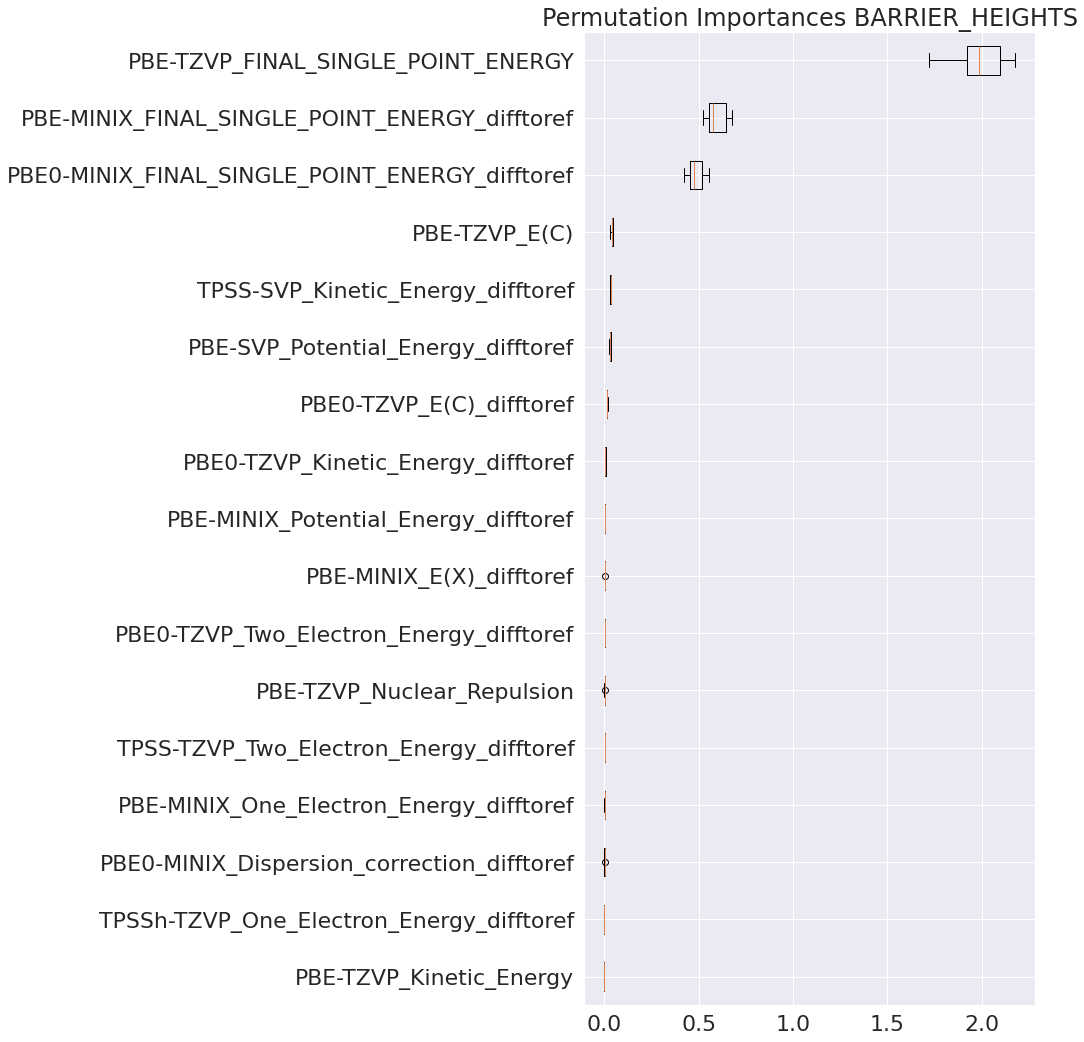

<Figure size 1080x1080 with 0 Axes>

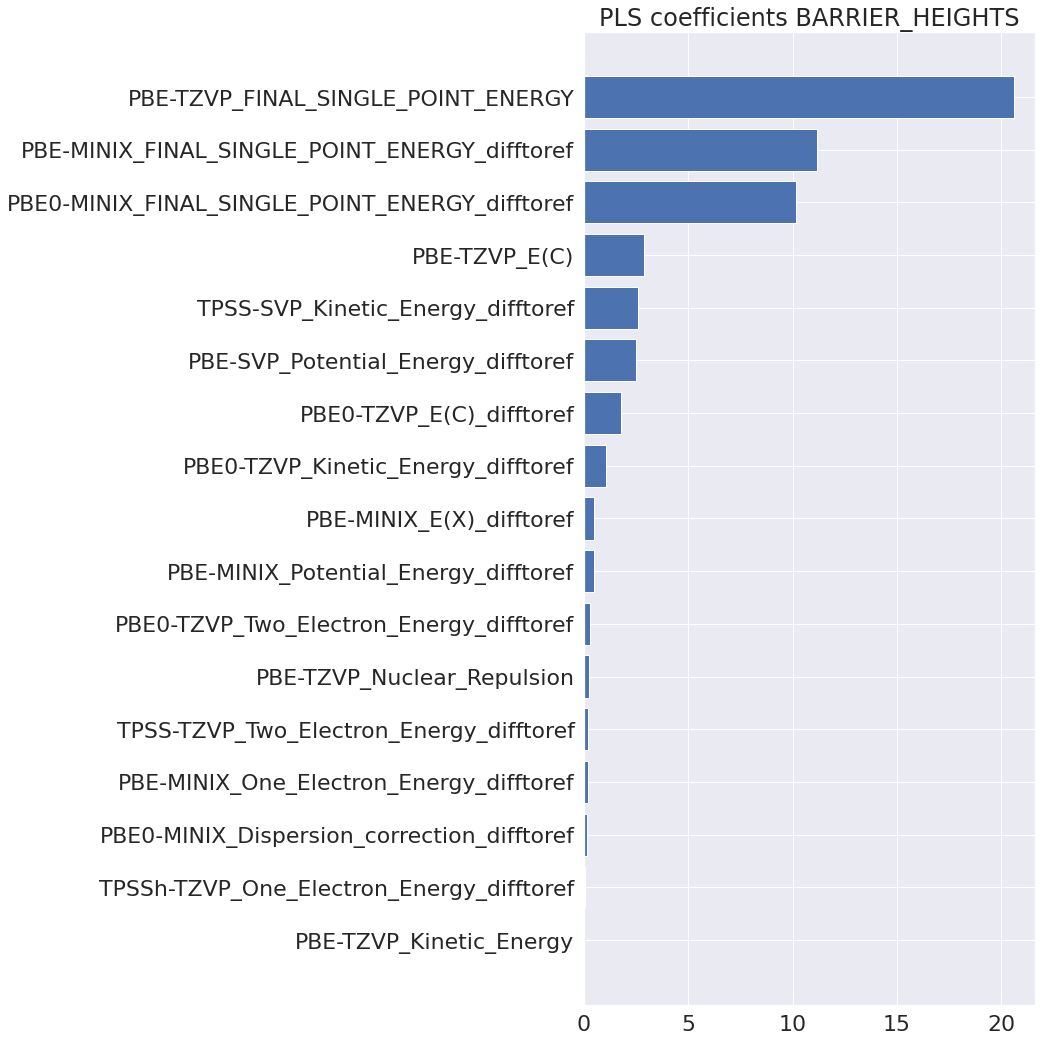

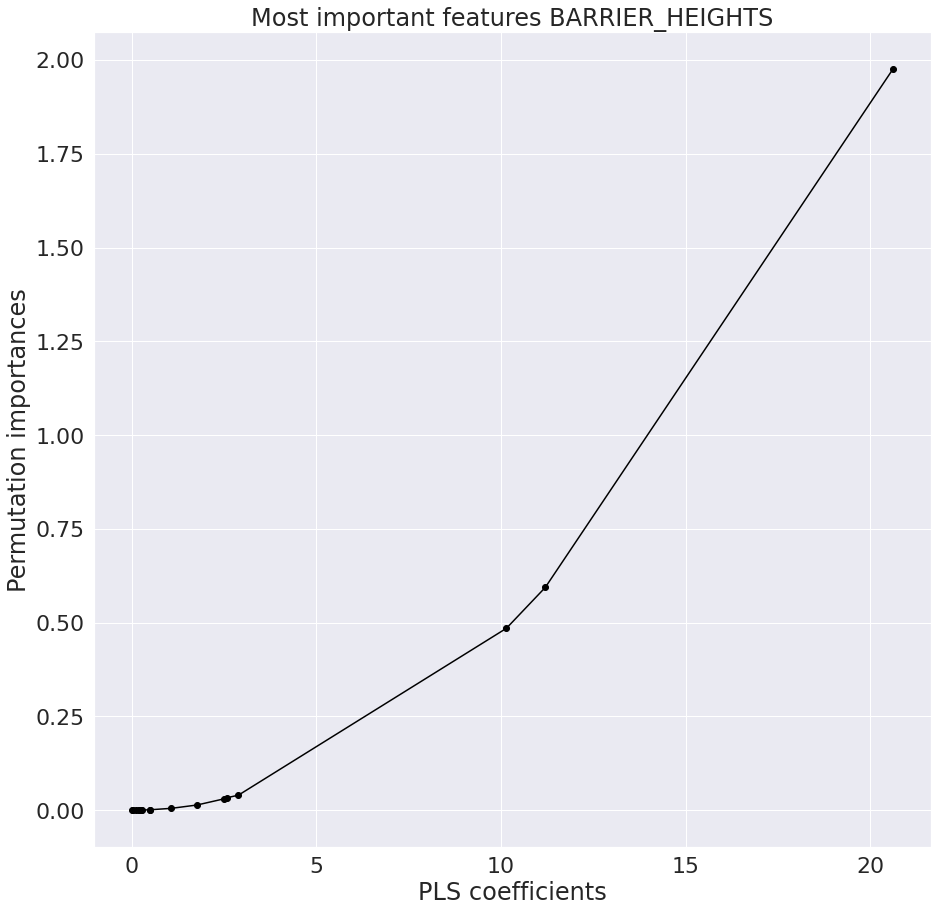

<Figure size 1080x1080 with 0 Axes>

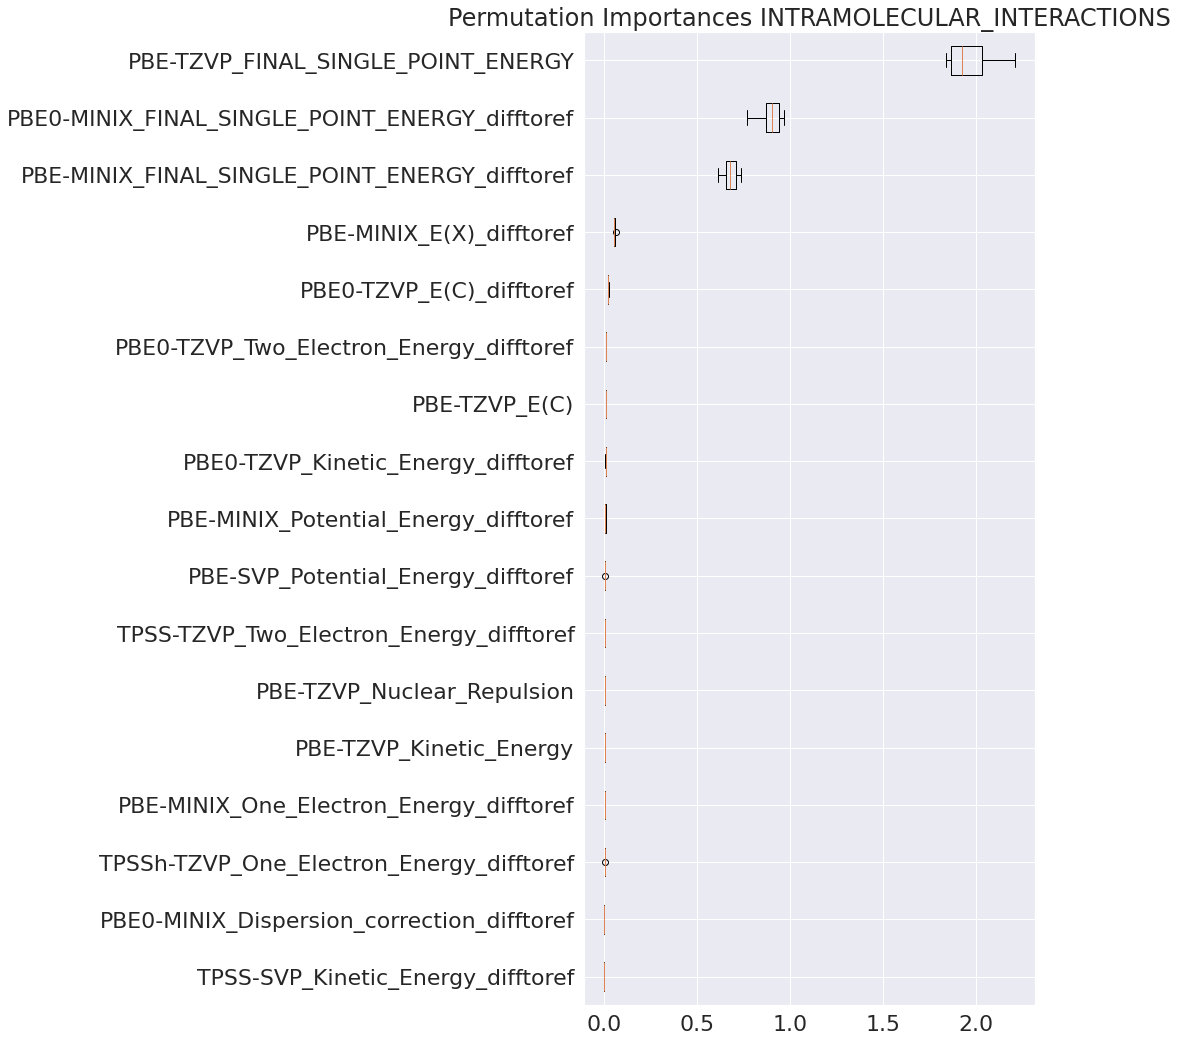

<Figure size 1080x1080 with 0 Axes>

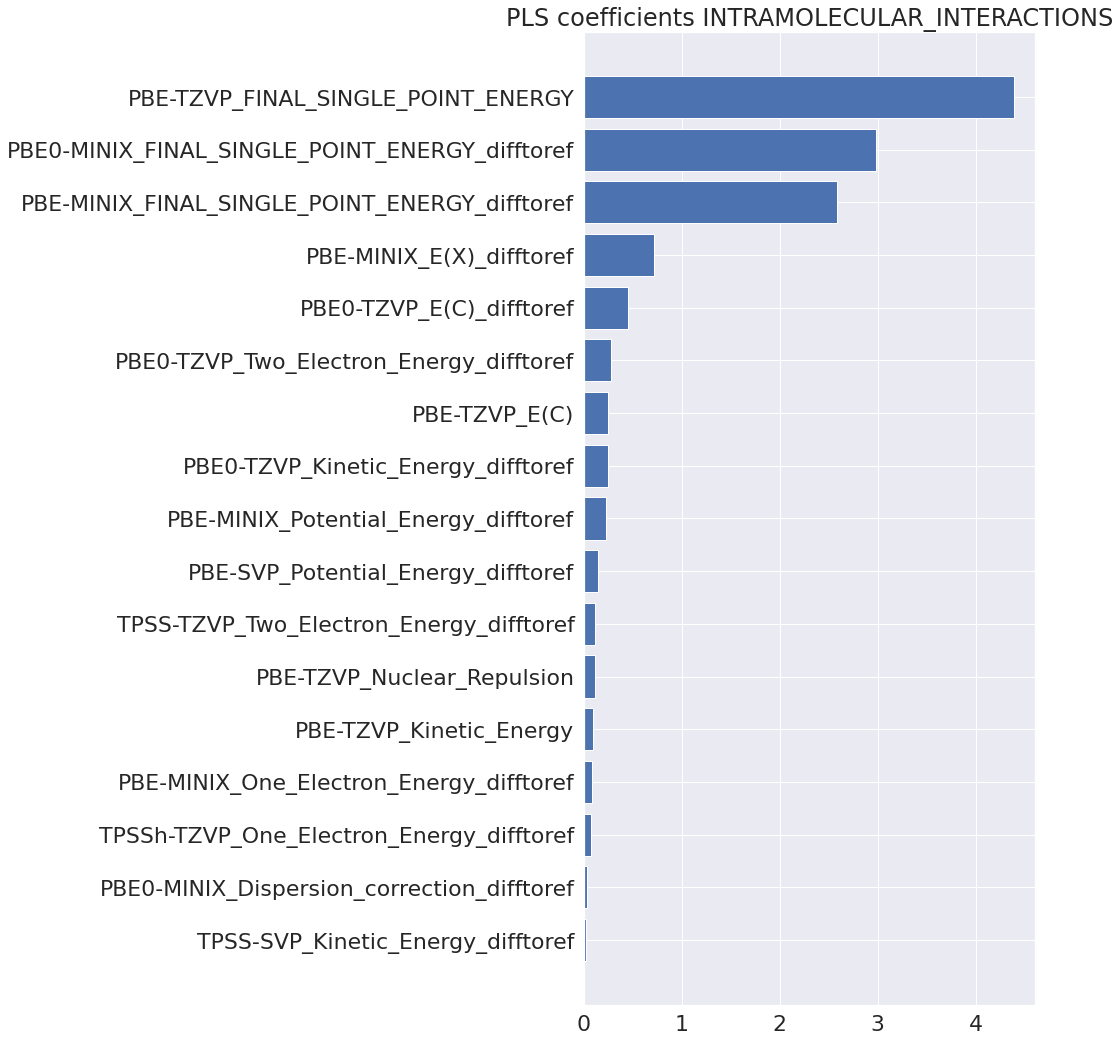

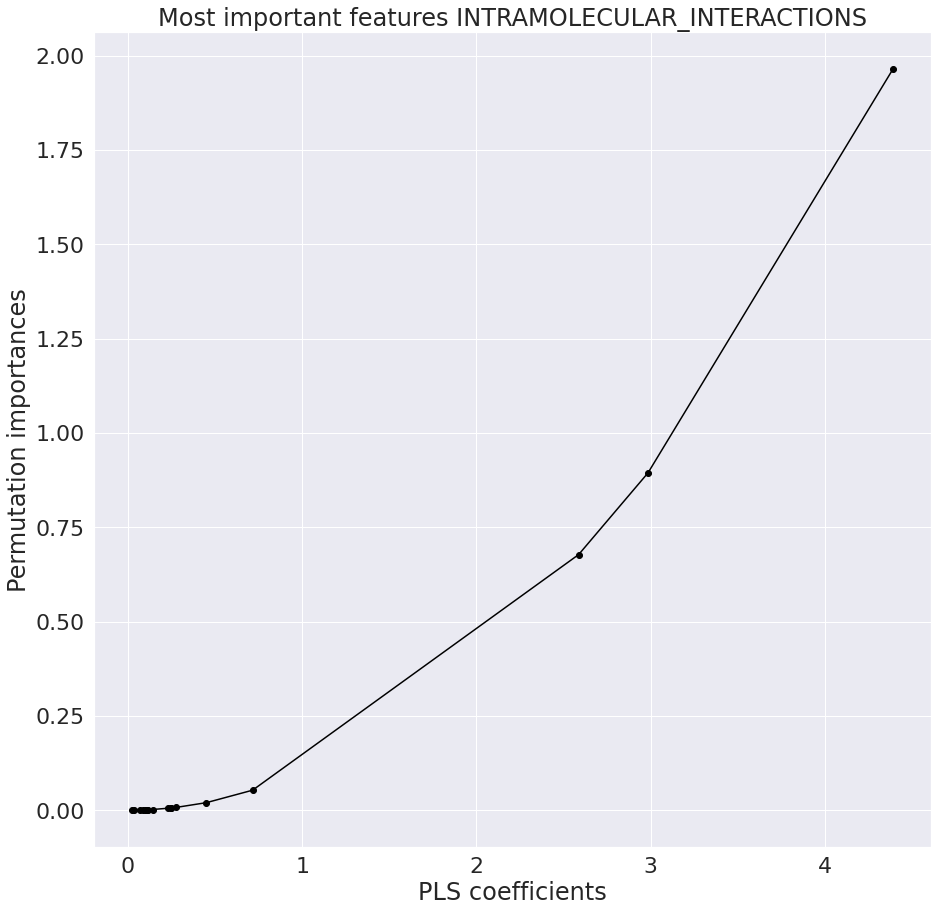

<Figure size 1080x1080 with 0 Axes>

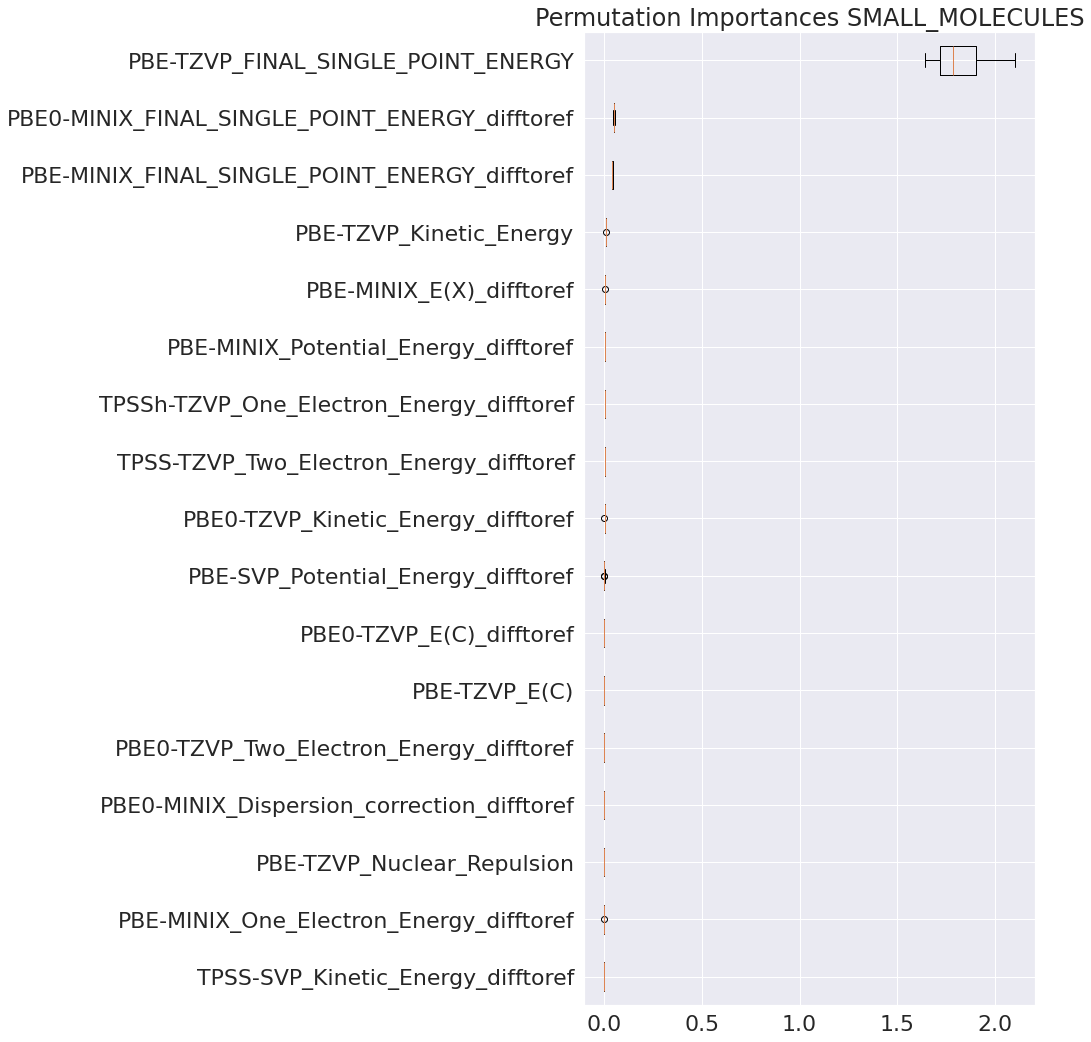

<Figure size 1080x1080 with 0 Axes>

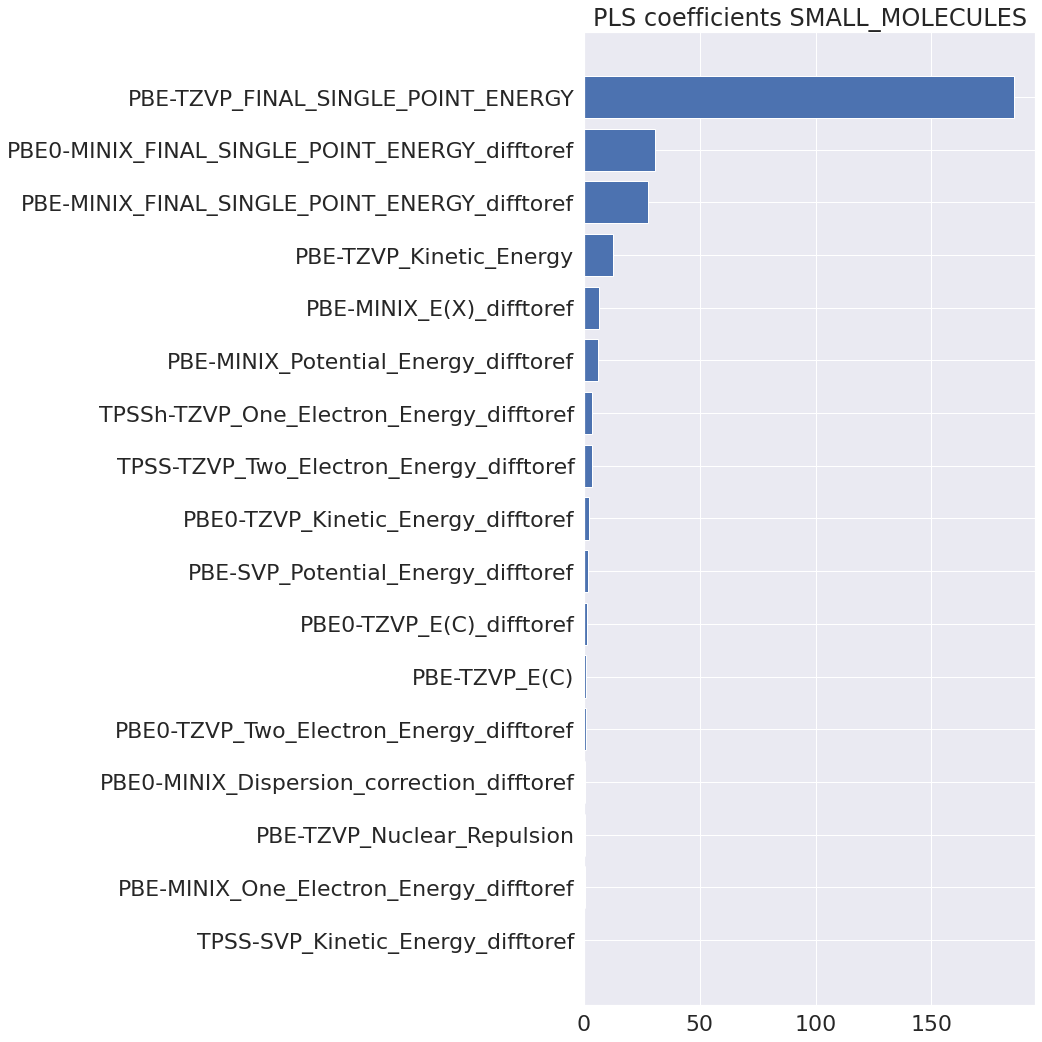

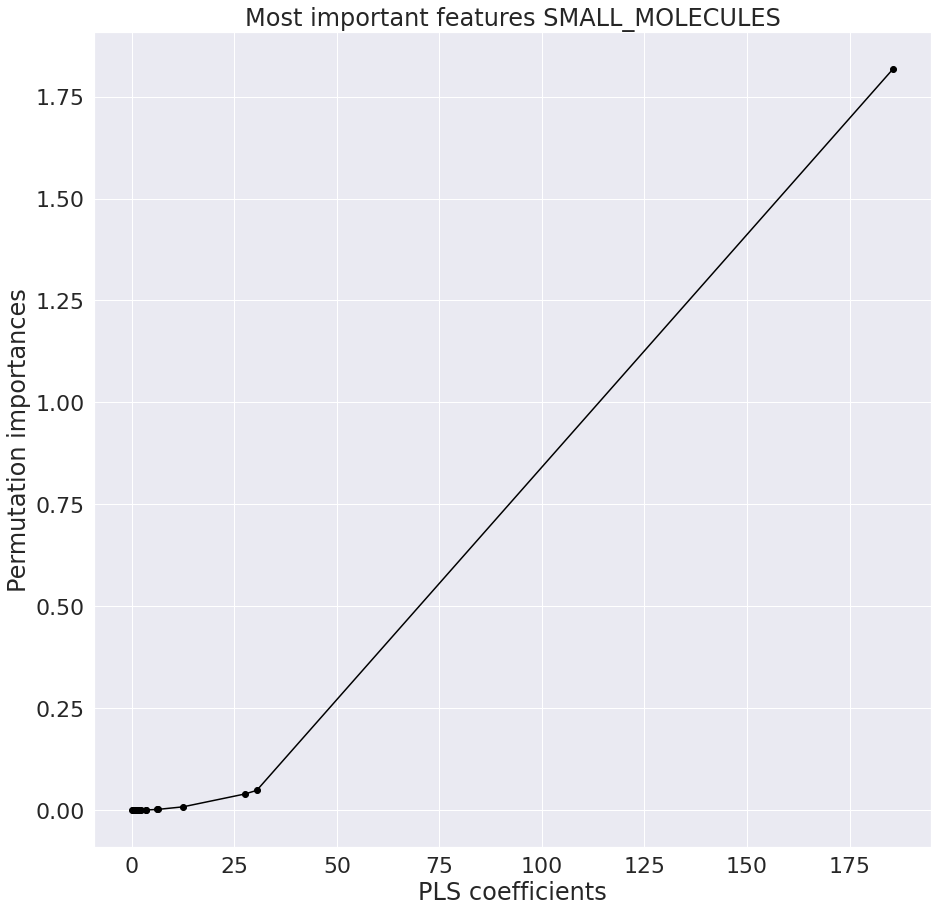

<Figure size 1080x1080 with 0 Axes>

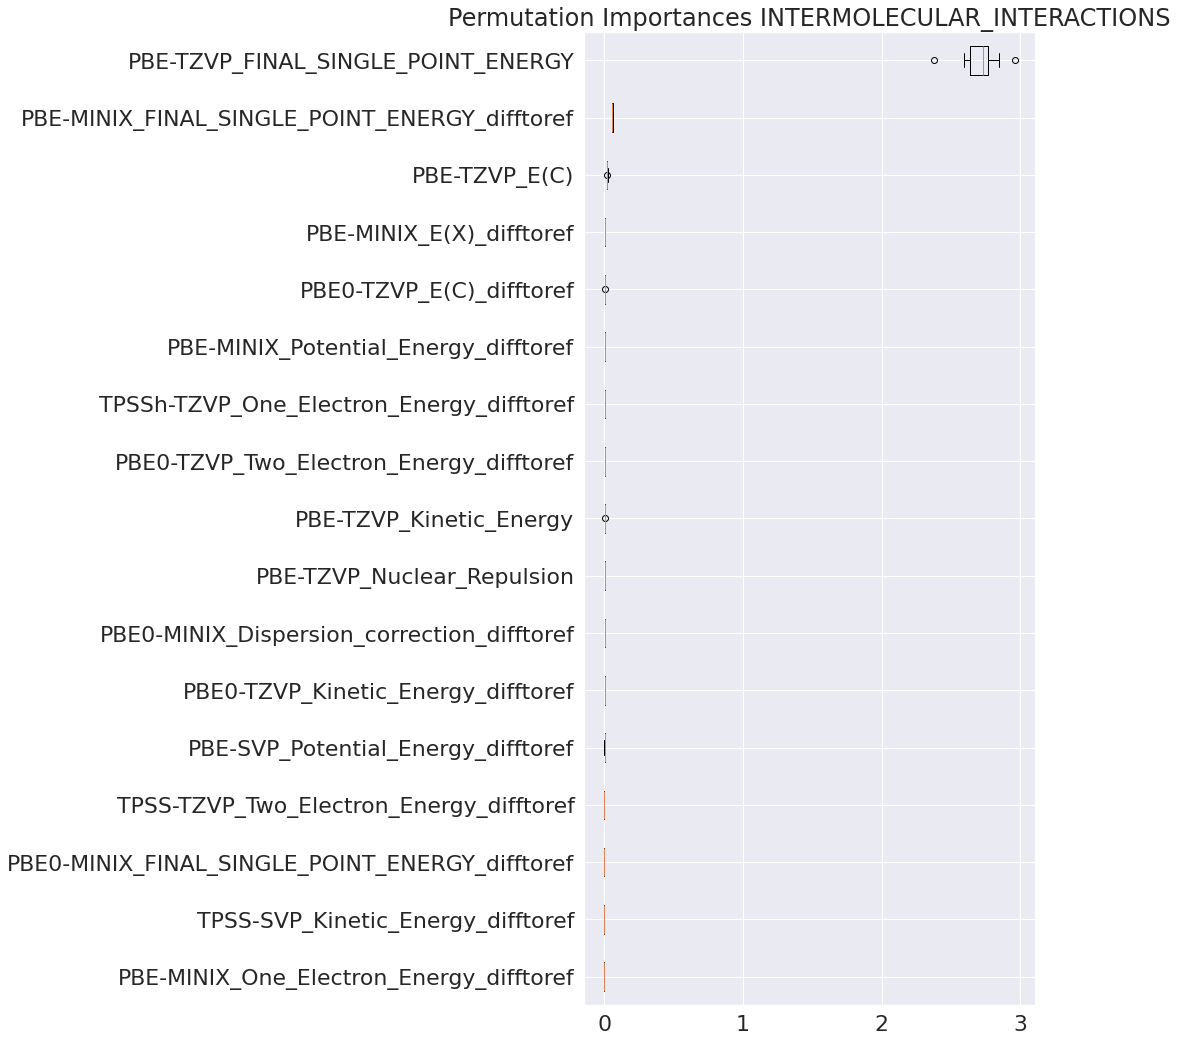

<Figure size 1080x1080 with 0 Axes>

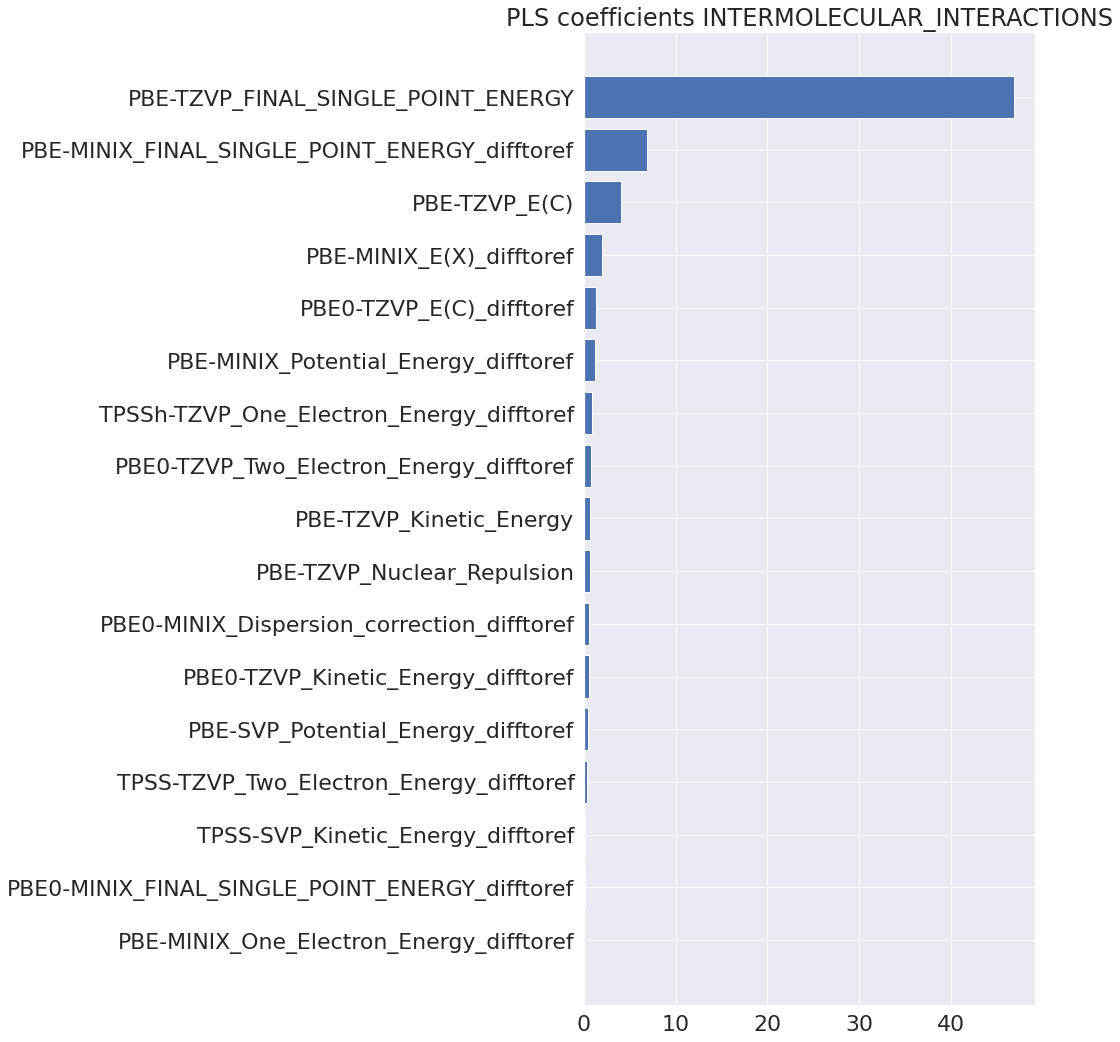

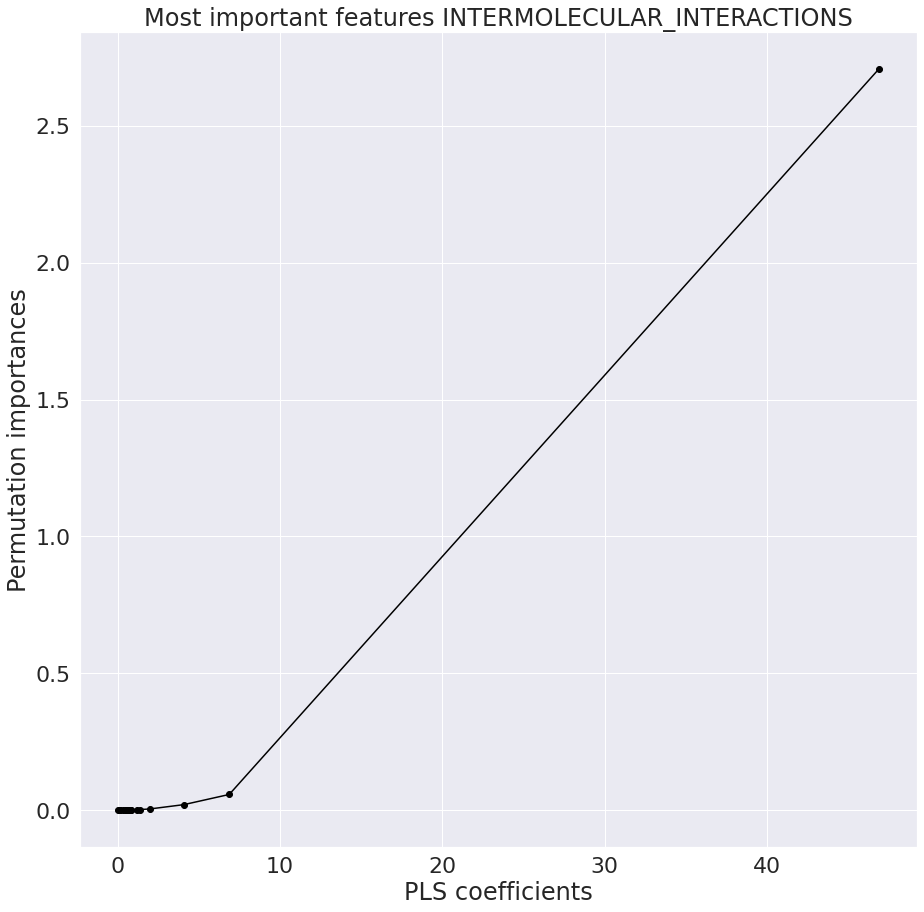

<Figure size 1080x1080 with 0 Axes>

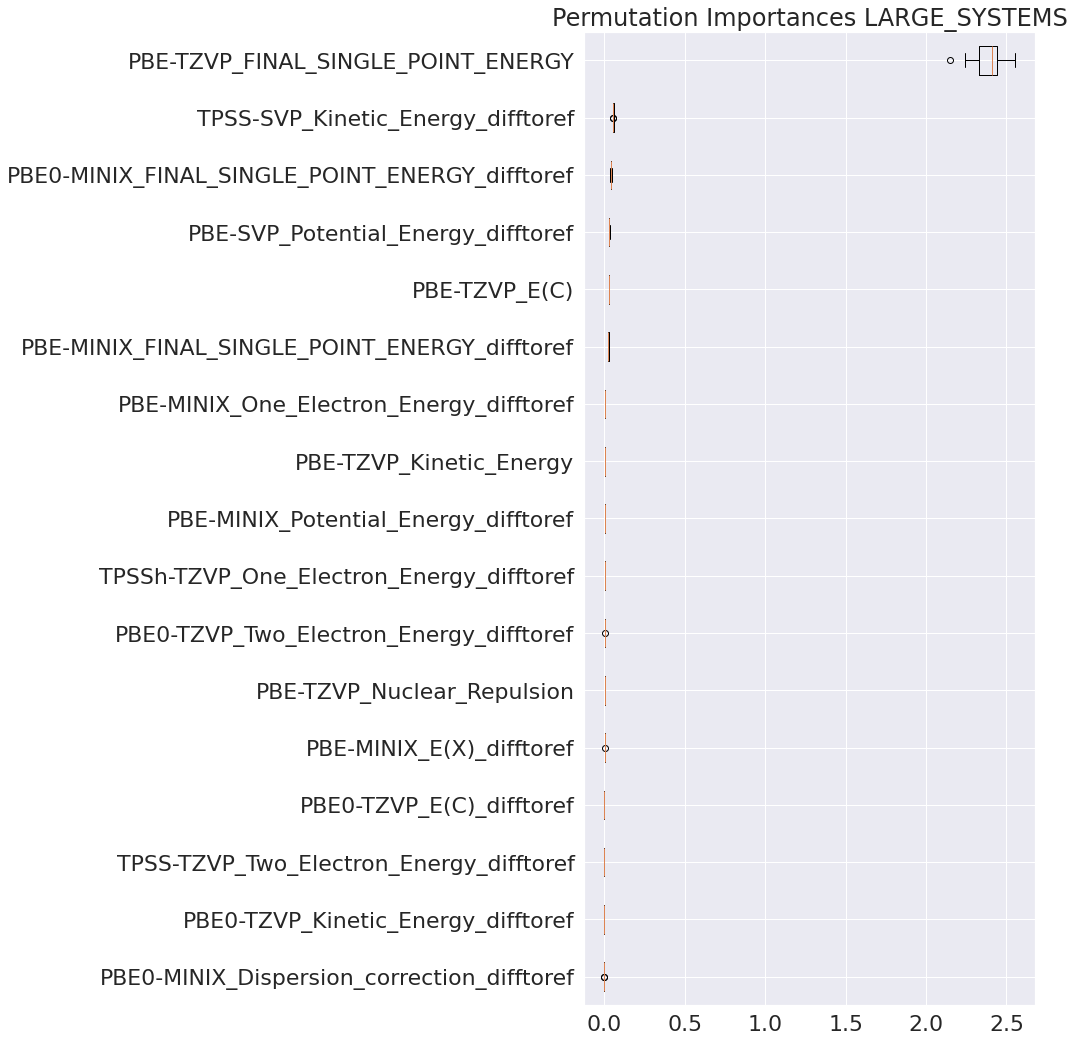

<Figure size 1080x1080 with 0 Axes>

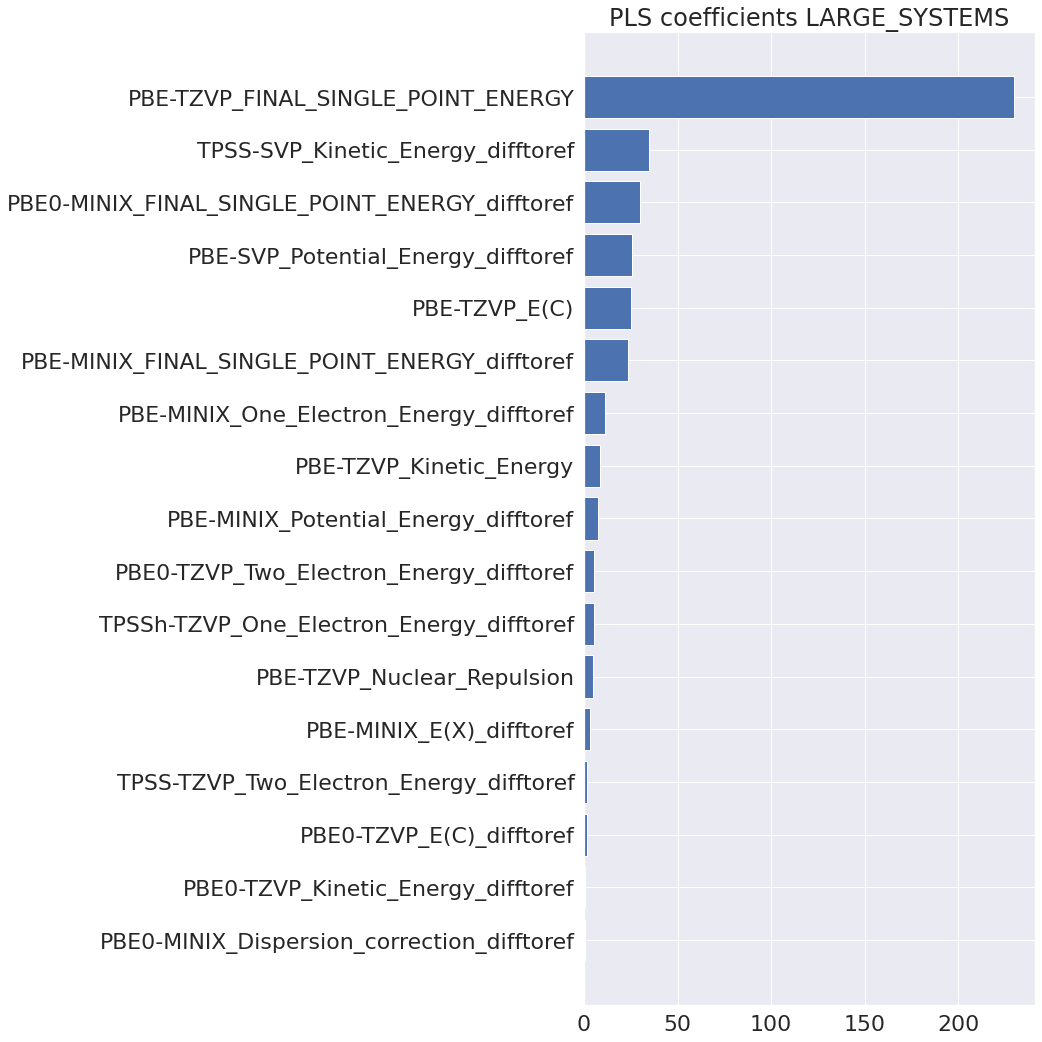

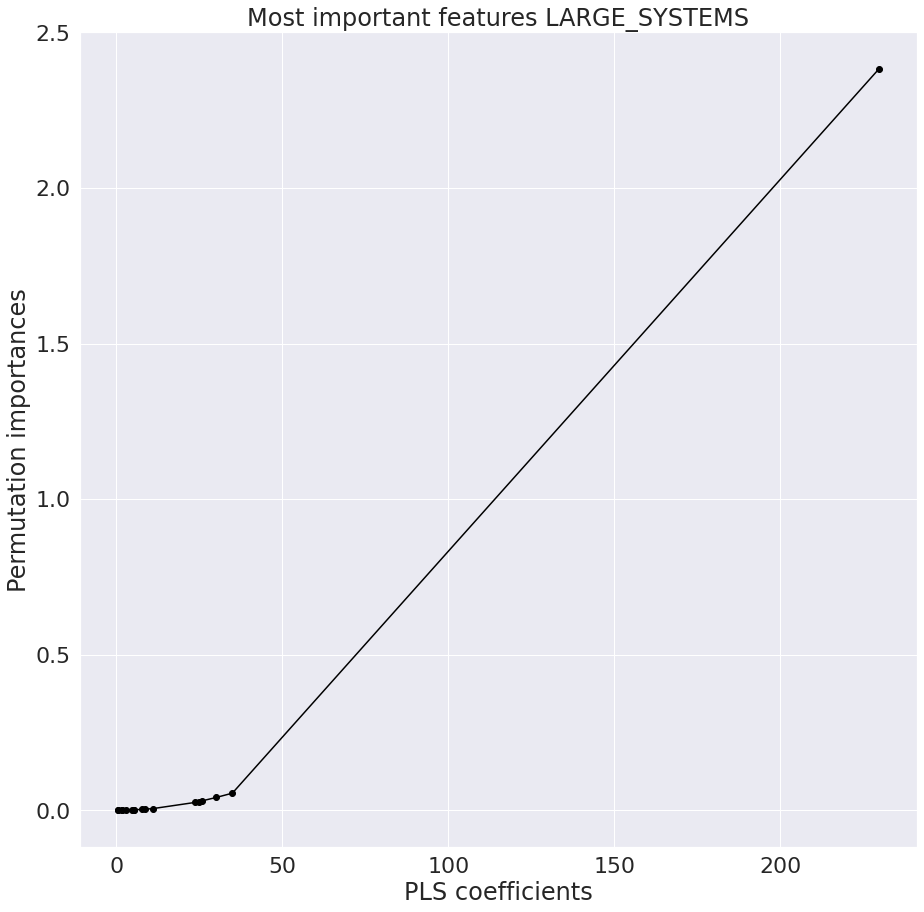

<Figure size 1080x1080 with 0 Axes>

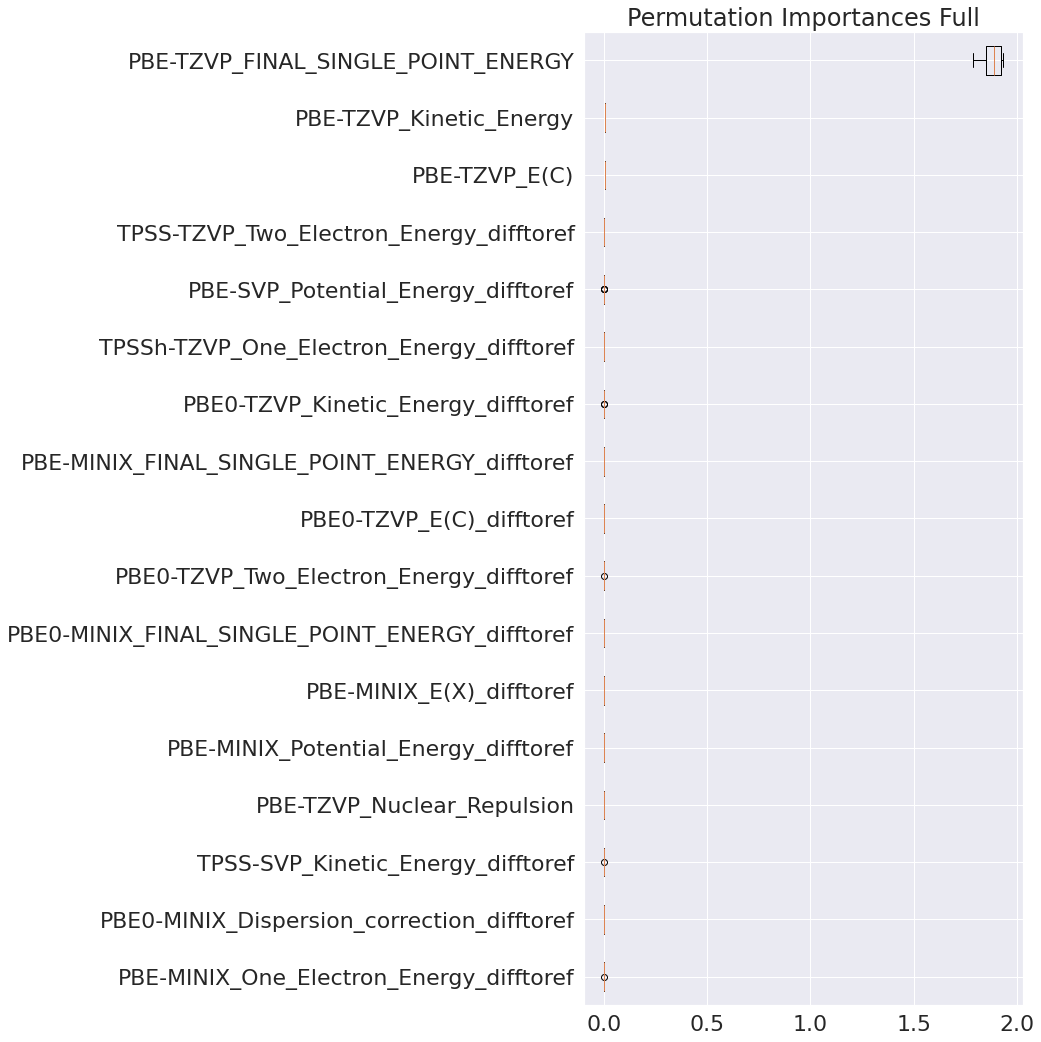

<Figure size 1080x1080 with 0 Axes>

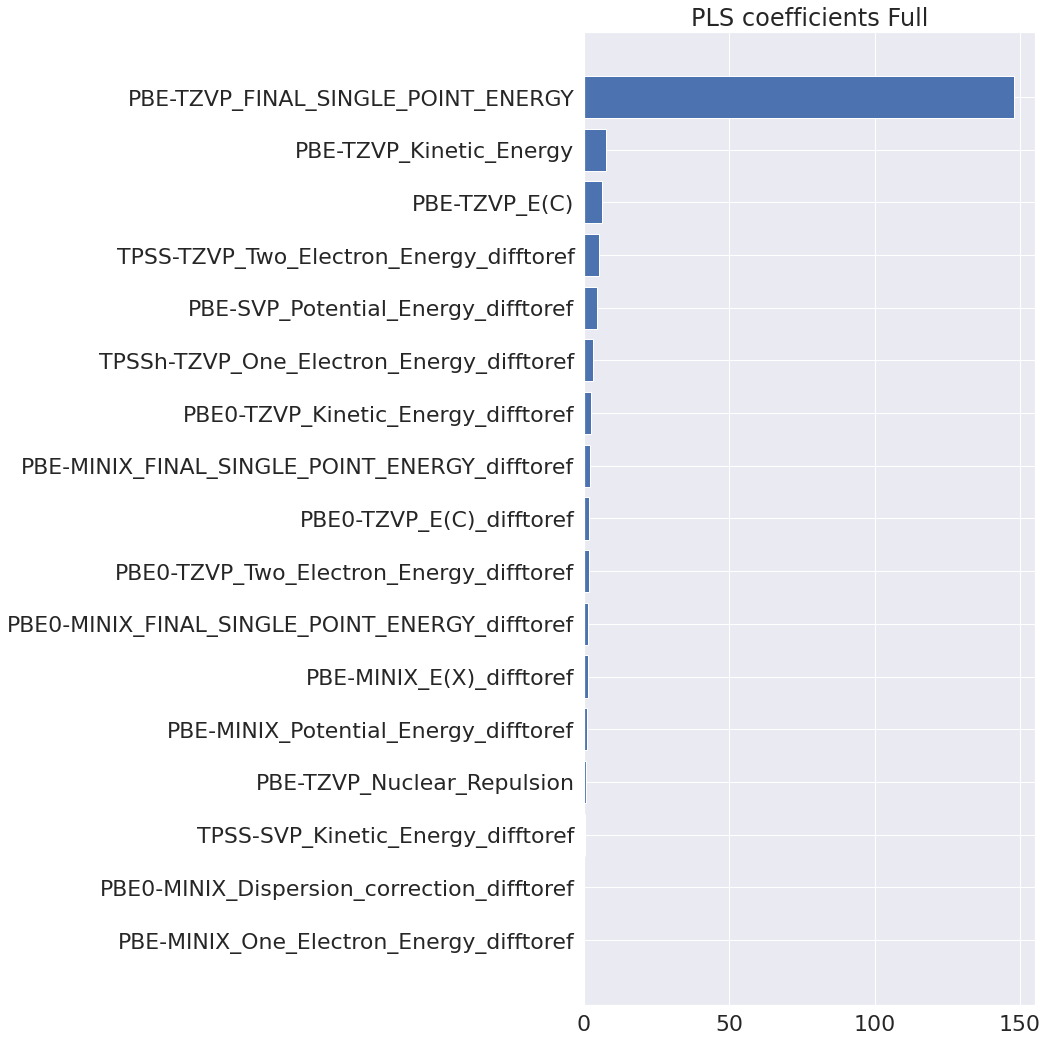

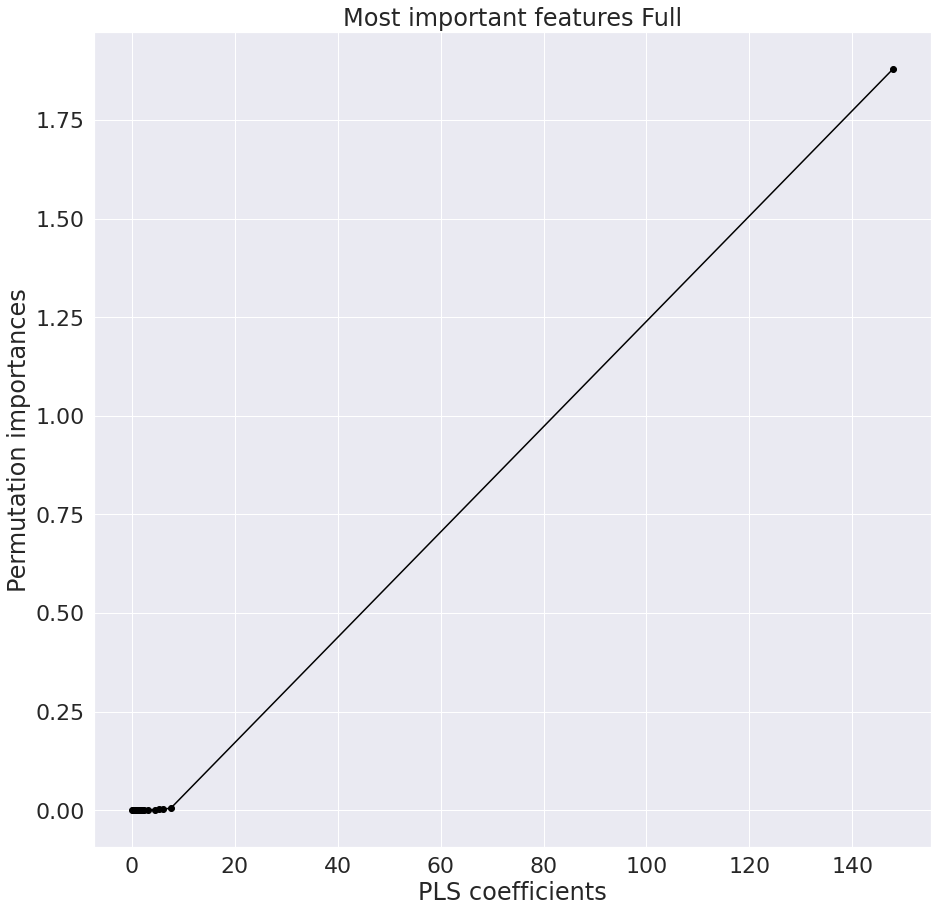

In [34]:
# perform features importance analysis
for setname in list(supersetnames)+["Full"]:   

    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    model = models_results[setname].plsmodel
    result = permutation_importance(model, X, Y, n_repeats=10, \
                                random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    plt.clf()
    plt.rcParams['figure.figsize'] = 15,15
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, \
               labels=np.array(features_names)[sorted_idx])
    ax.set_title("Permutation Importances " + setname)
    fig.tight_layout()
    plt.show()
    
    #compute absolute values of the PLS coefficients
    coef = np.abs(model.coef_).flatten()
    #sort the coefficients
    sorted_idx = np.argsort(coef)
    plt.clf()
    plt.rcParams['figure.figsize'] = 15,15
    fig, ax = plt.subplots()
    ax.barh(np.array(features_names)[sorted_idx], \
            coef[sorted_idx])
    ax.set_title("PLS coefficients " + setname)
    fig.tight_layout()
    plt.show()

    # scatter plot of the most important features
    plt.clf()
    plt.rcParams['figure.figsize'] = 15,15
    fis = [np.mean(result.importances[i].T) for i in sorted_idx]
    cfs = [coef[i] for i in sorted_idx]
    plt.plot(cfs, fis, '-o', color='black')
    plt.xlabel("PLS coefficients")
    plt.ylabel("Permutation importances")
    plt.title("Most important features " + setname)
    plt.show()
